<a href="https://colab.research.google.com/github/bhugh/FrequencyFingerprint/blob/main/MIDI_File_Frequency_Fingerprint_Generator_v2_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FREQUENCY FINGERPRINTS**
**With this notebook you can generate a FREQUENCY FINGERPRINT of a musical work.** The Frequency Fingerprint totals up all the pitches of notes of the work, weighted by the number of times each note was played and how long it was held. You can then both hear and see the results.  Average & most commonly played pitches are also shown.

This notebook comes pre-loaded with Frequency Fingerprint analysis of the three movements of the Moonlight Sonata - which give some really interesting insights into the Sonata. So first, scroll down to view and listen to those samples.

Second: Generating your own Frequency Fingerprints from one or more MIDI files is as easy as 1-2-3:

1. ***Initialize*** - Click the *RUN* button just under that heading to get the code ready to run
2. ***Upload the files*** - Click the *RUN* button here and an upload box will appear.
3. ***Process the files*** - After you have uploaded the files and put them in the order you like, click "Process Files" and you will see the result!

To process more files, go back to [Step #2. Upload the MIDI Files](#scrollTo=Upload_the_MIDI_Files) and press the PLAY button (on the left) again.

*>>>>More details about Frequency Fingerprints and this project down at the bottom: [What is a Frequency Fingerprint - and Why](#scrollTo=Frequency_Fingerprints_results_what_you_are_hearing_and_seeing), [Details & Credits](#scrollTo=Frequency_Fingerprints_results_what_you_are_hearing_and_seeing)*


#1. Initialize
***>>>>Click the "Play" button just below to the left. This will run the needed initialization routines. Wait until it completes - it may take a minute or so.***


*   *Usually this section doesn't need to run again unless the session terminates or crashes.  If you receive error messages when uploading or processing files, you can try Initializing again to solve them.*

In [1]:
# @title
!apt install fluidsynth
!pip install mido
!apt install python3-pyaudio
!pip install librosa
!pip install pretty_midi  # Install required library
#!apt install fluidsynth # Install fluidsynth for MIDI playback
!pip install pyfluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2 # Copy a soundfont

import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from scipy.signal.windows import hamming
from google.colab import files
#from music21 import converter, instrument
#import fluidsynth
import time

#import sounddevice as sd
#sd.query_devices()
# %%capture

#initialize default values for sliders & checkboxes etc
histogram_checkbox_value = True
spectrum_checkbox_value = False
waveform_s_checkbox_value = False
waveform_f_checkbox_value = False
duration = 2
smoothness_slider_value = 5
filenames = []
sample_rate = 44100 # Sampling rate in Hz (for fingerprint audio files)

print ("inited")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icc

##Process MIDI (Utility Cell 1)

In [2]:
# @title
# this cell based on code by u/CptanPanic - https://www.reddit.com/r/classicalmusic/comments/1gpcjtd/comment/lwqda1g/

import mido

def midi_number_to_name(note_number, column = False):

    """Convert a MIDI note number to its corresponding note name."""

    # Define the note names and their corresponding MIDI numbers

    note_names = [

        'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'

    ]
    note_names_column = [

        'C ', 'C#', 'D ', 'D#', 'E ', 'F ', 'F#', 'G ', 'G#', 'A ', 'A#', 'B '

    ]
    if (column):
        note_names = note_names_column

    # Calculate the octave and the note name

    octave = (note_number // 12) - 1 # MIDI note 0 is C-1

    note_name = note_names[round(note_number) % 12]

    return f"{note_name}{octave}"

def calculate_note_frequency_counts(midi_file_path):

    # Load the MIDI file

    mid = mido.MidiFile(midi_file_path)

    # List to store note frequency count
    count = 0
    ticks_per_beat = mid.ticks_per_beat

    note_frequency_count = [0] * 128
    note_values = []
    # Iterate through all the tracks in the MIDI file

    for track in mid.tracks:
        notes_sounding = [-1] * 128
        count = 0
        elapsed_time_ticks = 0

        for msg in track:
            #print(msg)
            count += 1
            #if count > 250:
            #    break
            #if count < 250:
            #    print(msg)

        # Check if the message is a note_on message
            elapsed_time_ticks += msg.time

            if msg.type == 'note_on' and msg.velocity > 0:
                #for now we are counting each note struck in the histogram
                #With midi, calculating the actual time each note is held gets
                #pretty tricky
                #note_frequency_count[msg.note] += 1
                notes_sounding[msg.note] = elapsed_time_ticks
                note_values.append(msg.note)

            if msg.type == 'note_off' or ( msg.type == 'note_on'and msg.velocity == 0 ):
                if notes_sounding[msg.note] >= 0 and elapsed_time_ticks - notes_sounding[msg.note] >= 0:
                    time_played_ticks = elapsed_time_ticks - notes_sounding[msg.note]
                    real_played_ticks = time_played_ticks
                    if  time_played_ticks > 10*ticks_per_beat:
                        time_played_ticks = 10*ticks_per_beat
                    note_frequency_count[msg.note] += time_played_ticks
                    notes_sounding[msg.note] = -1
                    #if count < 250:
                    #    print (msg.note, real_played_ticks, time_played_ticks, note_frequency_count[msg.note])


    # Calculate the average note

    if note_values:

        average_note = sum(note_values) / len(note_values)
        out1 =  (str.format("Average note: MIDI Note #{:.2f} - {}{:+.2f} cents - {:.2f}hz", average_note, midi_number_to_name(round(average_note)),average_note-round(average_note),calculate_note_frequency(average_note)))
        weighted_ave = weighted_average(note_frequency_count)
        out3 =  (str.format("Weighted Average note: MIDI Note #{:.2f} - {}{:+.2f} cents - {:.2f}hz", weighted_ave, midi_number_to_name(round(weighted_ave)),weighted_ave-round(weighted_ave), calculate_note_frequency(weighted_ave)))
        most_common = index_of_largest_list_member(note_frequency_count)
        out2 =  (str.format("Most commonly played note: MIDI Note #{} - {} - {:.2f}hz", most_common, midi_number_to_name(most_common),calculate_note_frequency(most_common)))
        display(HTML("<p><b>" + out1 + "</b></p>"))
        display(HTML("<p><b>" + out2 + "</b></p>"))
        display(HTML("<p><b>" + out3 + "</b></p>"))

    return note_frequency_count, out1, out2, out3, average_note, weighted_ave, most_common

def calculate_white_note_frequencies():

    # List to store note frequencies

    note_frequencies = []
    note_labels = []

    for f in range(21,109,1):
        note_freq = 440 * 2**((f-69)/12)
        note_name = midi_number_to_name(f)
        note_frequencies.append( note_freq)
        if note_name.find('#') <= 0:

            if (note_name.find('C') >= 0):
              note_name=note_name[0:2]
            else:
              note_name=note_name[0:1]
            if (note_name.find('A') >= 0):
                note_name += f"\n{note_freq:.0f}"
            note_labels.append(note_name)
        else:
          note_labels.append('#')
    #print (note_frequencies)
    #print (note_labels)

    return note_frequencies, note_labels

def calculate_note_frequencies():

  # List to store note frequencies

  note_frequencies = [0] * 128 # this needs to correspond exactly to list note_frequency_count

  for f in range(0,127,1):
      note_frequencies[f] = 440 * 2**((f-69)/12)

  return note_frequencies


def calculate_note_frequency(note):

    return 440 * 2**((note-69)/12)


def largest_nonzero_index(lst):
    for i in range(len(lst) - 1, -1, -1):
        if lst[i] != 0:
            return i
    return 0

def index_of_largest_list_member(lst):
    max = 0
    save = None
    for i in range(0, len(lst) - 1, 1):
        if lst[i] > max:
            max = lst[i]
            save = i

    return save

def weighted_average(lst):
    total = 0
    divisor = 0
    for i in range(0, len(lst) - 1, 1):
        total += i*lst[i]
        divisor += lst[i]

    if divisor == 0:
        divisor = 1

    return total/divisor





##Create Results (Utility Cell 2)

In [47]:
# @title
#using FluidSynth

import ipywidgets as widgets
from IPython.display import display, HTML
import os
from pydub import AudioSegment

def create_results(input_midi_file):
    global duration, sample_rate, smoothness  # Declare duration and sample_rate as global

    #out = widgets.Output()
    #display(out)

    #display(HTML("<p><h3>Choose which elements to display:</h3>"))
    display(HTML("<p>&nbsp;</p>"))
    display(HTML("<p>&nbsp;</p>"))
    display(HTML("<p><b>=========================================================================================</b></p>"))
    display(HTML("<p><b>========  RESULTS  =========================================================================</b></p>"))
    display(HTML("<p><b>=========================================================================================</b></p>"))
    display(HTML("<p>&nbsp;</p>"))
    display(HTML("<p>Input file:" + input_midi_file + "</p>"))
    display(HTML("<p>&nbsp;</p>"))
    frequencies = calculate_note_frequencies()
    amplitudes, msg1, msg2, msg3, average_note, weighted_ave, most_common = calculate_note_frequency_counts(input_midi_file)
    print()

    max_note = largest_nonzero_index(amplitudes)
    max_freq = frequencies[max_note]
    max_frequency_to_display_on_plots = max_freq
    #max_frequency_to_display_on_plots = max(frequencies) * 1.5

    # Time array
    time = np.linspace(0, duration, int(sample_rate * duration))

    # Generate the signal by summing sine waves of different frequencies
    #signal = np.sum([amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * time) for i in range(len(frequencies))], axis=0)
    #fact = np.sqrt(10)/2 # if we want to double the perceptual sound,  doubling amplitude doesn't quite do it.  We need to increase by a factor of sqrt(10) rather than a factor of 2.  So adding this factor in should make the needed adjustment.
    #This is however meaningless because it just multiplies all values in the signal by a certain value
    #later we are going to normalize it, anyway...
    # So sqrt (amplitudes[i]) (or smoothness = 1/2) is probably the "most accurate" representation of the various magnitudes, as perceived by the human ear
    # Because perceived loudness is roughly proportional to the "power" which is the square of the magnitude
    if smoothness<=0:
      smoothness = 0.00001

    signal = np.sum([amplitudes[i]**smoothness * np.sin(2 * np.pi * frequencies[i] * time) for i in range(len(frequencies))], axis=0)
    #print ("SIGNL",len(signal), signal.size, signal.ndim,signal.shape,signal.base)
    # Normalize the signal
    signal = signal / np.max(np.abs(signal))*0.2 # These are quite dissonant so seem to come across better if a bit quieter.
    signal = fade_in_out_audio (signal, fade_duration=0.02, sr=sample_rate)
    #print ("SIGNL",len(signal), signal.size, signal.ndim,signal.shape,signal.base)
    save_signal=signal.copy() # saving w/o the fade in/out

    signal = fade_in_out_audio (signal, fade_duration=0.02, sr=sample_rate)

    audio = Audio(data=signal, rate=sample_rate, normalize=False)
    display(audio)

    # Create a button widget
    button = widgets.Button(description="Process and Play")

    # Define a function to be executed when the button is clicked
    def on_button_clicked(b):
      # Clear previous output
      clear_output()

      # Get the MIDI file path (you'll need to define this)
      midi_file_path = input_midi_file

      # Process and play the MIDI file
      #process_and_play_midi(midi_file_path)
      midi_play_widget(input_midi_file)

    # Attach the function to the button's click event
    button.on_click(on_button_clicked)

    # Display the button
    display(button)



    """
    # Create a button
    download_button = widgets.Button(description="Download MIDI File")

    # Define the function to be executed when the button is clicked
    def on_button_clicked(b):
      files.download(input_midi_file)
      #print ("The MIDI file was downloaded...")
      #display(HTML(download_link(input_midi_file)))

    # Attach the function to the button's click event
    download_button.on_click(on_button_clicked)

    # Display the button
    display(download_button)
    """

    # Create an Audio object and display it


    #This is not interesting for Frequency Fingerprint purposes
    #Plot the spectrogram
    #plt.figure(figsize=(14, 4))
    #plt.specgram(signal, Fs=sample_rate)
    #plt.title('Spectrogram')
    #plt.xlabel('Time (s)')
    #plt.ylabel('Frequency (Hz)')
    #plt.ylim(0, max_frequency_to_display_on_plots)
    #plt.show()

    #This is not interesting for Frequency Fingerprint purposes
    #NFFT = 1024
    #noverlap = NFFT // 2
    #plt.figure(figsize=(14, 4))
    #plt.specgram(signal, Fs=sample_rate, window=hamming(NFFT), NFFT=NFFT, noverlap=noverlap)
    #plt.title('Spectrogram (hamming)')
    #plt.xlabel('Time (s)')
    #plt.ylabel('Frequency (Hz)')
    #plt.ylim(0, max_frequency_to_display_on_plots)
    #plt.show()

    xticks, xlabels = calculate_white_note_frequencies()

    ##################################################################
    # HISTOGRAM of note frequencies
    frequencies = [f if f > 0 else 1e-10 for f in frequencies]
    bar_widths = [(frequencies[i+1] - frequencies[i])/2 for i in range(len(frequencies)-1)]
    bar_widths.append(bar_widths[-1])  # Add the last bar width

    import re
    nice_filename=os.path.splitext(os.path.basename(input_midi_file))[0]
    nice_filename = nice_filename.replace('-', ' ').replace('_', ' ')
    nice_filename = re.sub(r'\(\d+\)$', '', nice_filename)

    if histogram_checkbox.value:
      fig, ax = plt.subplots() # Create a figure and an axes object
      fig.set_size_inches(20, 9)
      ax.bar(frequencies, amplitudes, width=bar_widths, align='center')  # Use ax to plot
      ax.set_xlabel('Note/Frequency (Hz)\nFREQUENCY FINGERPRINT HISTOGRAM')
      ax.set_ylabel('Duration Count (MIDI ticks)')
      plt.title(msg1 + "\n" + msg3 + "\n" + msg2 + "\n\n\n\n")
      fig.text(0.051,0.022, nice_filename, ha='center', va='bottom', fontsize=10)
      #ax.set_xlim([0, max_frequency_to_display_on_plots])  # Limit to positive frequencies
      ax.set_xlim([40, 4200])  # Limit to positive frequencies
      ax.set_xscale('log') # Set xscale on the axes object
      ax.set_xticks(xticks, labels=xlabels)

      maxa = np.max(amplitudes)
      top_border_y = ax.get_ylim()[1]

      ################ Add AVERAGE
      ave_frq= calculate_note_frequency(average_note)
      plt.annotate(
          "Ave",
          xy=(ave_frq, top_border_y),  # Arrow tip at bin center and slightly above bin height
          xytext=(ave_frq, top_border_y*1.03),  # Arrow tail at bin center and further above
          arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="green", linewidth=2),
          color="green",
          ha='center' # Add this line to center the text horizontally
      )

      ################ Add WEIGHTED AVERAGE
      ave_frq= calculate_note_frequency(weighted_ave)
      plt.annotate(
          "W. Ave",
          xy=(ave_frq, top_border_y),
          xytext=(ave_frq, top_border_y*1.06),
          arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="red", linewidth=2),
          color="red",
          ha='center' # Add this line to center the text horizontally
      )

      ########################## Standard DEVIATION
      sd = std_dev_binned(amplitudes)
      sd_frq_low= calculate_note_frequency(weighted_ave-sd)
      sd_frq_high= calculate_note_frequency(weighted_ave+sd)
      #display(HTML(f"SD!!!!!!!!!!!!! sd: {sd}, sd_frq: {sd_frq_low}, sd_frq: {sd_frq_high}"))
      # Create a bracket-like annotation
      plt.annotate(
          "",  # Empty string for no text
          xy=(sd_frq_high, top_border_y ),  # Starting point of the bracket
          xytext=(sd_frq_low, top_border_y),  # Ending point of the bracket
          #arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=0.5', lw=2.0, color='black')
          arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="red", linewidth=1),
          va='center', ha='center',
          color="red"
      )
      plt.annotate(
          "SD",  # Empty string for no text
          xy=(sd_frq_high, top_border_y*.99 ),  # Starting point of the bracket
          xytext=(sd_frq_low, top_border_y*1.03),  # Ending point of the bracket
          #arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=0.5', lw=2.0, color='black')
          arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color="none", linewidth=1),
          va='center', ha='center',
          color="red"
      )


      ################ Add MOST COMMON
      ave_frq= calculate_note_frequency(most_common)
      plt.annotate(
          "Mode",
          xy=(ave_frq, top_border_y),  # Arrow tip at bin center and slightly above bin height
          xytext=(ave_frq, top_border_y*1.09),  # Arrow tail at bin center and further above
          arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="blue", linewidth=2),
          color="blue",
          ha='center' # Add this line to center the text horizontally
      )

      # Calculate the cumulative frequencies
      cumulative_freq = np.cumsum(amplitudes)

      # Find the median bin index
      median_bin_index = np.searchsorted(cumulative_freq, cumulative_freq[-1] / 2, side='right')

      median_frq = frequencies[median_bin_index]
      plt.annotate(
          "Median",
          xy=(median_frq, top_border_y),  # Arrow tip at bin center and slightly above bin height
          xytext=(median_frq, top_border_y*1.12),  # Arrow tail at bin center and further above
          arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="orange", linewidth=2),
          color="orange",
          ha='center' # Add this line to center the text horizontally
      )

      ################################################
      # for the MOVIE
      #
      # Save plot as NumPy array and convert to RGB directly:
       # Adjust layout to prevent clipping
      fig.tight_layout()
      fig.subplots_adjust(bottom=0.1, top=.75) #for more control
      fig.canvas.draw()
      image_data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
      image_data = image_data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
      image_data = image_data[:, :, :3].copy()  # Create a copy for RGB data

      #image = plt.savefig(format='png')  # Convert the figure to an image
      image_list.append(image_data)

      from PIL import Image
      Image.fromarray(image_data).save(f"/content/temp/image{len(image_list)}.png")

      plt.show()

      print()

      #plt.imshow(image_data)  # Display a generic image


    ##################################################################
    # FFT POWER of Fingerprint
    frequencies_proc = np.fft.fftfreq(len(time), 1/sample_rate)
    magnitude = np.fft.fft(signal)
    height = np.abs(magnitude)
    power = np.abs(magnitude) ** 2

    # Plot the periodogram
    #fig=plt.figure(figsize=(14, 4))
    #p = plt.plot(frequencies_proc, power)
    #plt.title('Histogram of Weighted Frequencies')
    #plt.xlabel('Frequency [Hz]')
    #plt.ylabel('Power')
    #plt.xlim([0, max_frequency_to_display_on_plots])  # Limit to positive frequencies
    ##fig.set_xscale('log')
    #lt.show()
    #xticks = [27.5, 33,41,49,65,82,97,131,165,196,262,330,392,523,659,784,1046,1318,1568,2092,2637,3136,4184]
    #xlabels = ['A0', 'C1\n33','E1', 'G1', 'C2\n65','E2','G2', 'C3\n131','E3','G3', 'C4\n262','E4','G4', 'C5\n523','E6','G5', 'C6\n1047','E6', 'G6','C7\n2093','E7','G7', 'C8\n4186']


    if spectrum_checkbox.value:
      fig, ax = plt.subplots() # Create a figure and an axes object
      fig.set_size_inches(20, 5)
      ax.plot(frequencies_proc, power)  # Use ax to plot
      ax.set_xlabel('Note/Frequency (Hz)\nFREQUENCY FINGERPRINT SPECTRUM')
      ax.set_ylabel('Power')
      plt.title(msg1 + "\n" + msg3 + "\n" + msg2 + "\n")
      fig.text(0.51, -0.1, os.path.basename(input_midi_file), ha='center', va='bottom', fontsize=8)
      #ax.set_xlim([0, max_frequency_to_display_on_plots])  # Limit to positive frequencies
      ax.set_xlim([40, 4200])  # Limit to positive frequencies
      ax.set_xscale('log') # Set xscale on the axes object
      ax.set_xticks(xticks, labels=xlabels)
      plt.show()

      print()


    """
    #This is usefull to see exactly what amplitudes were added to the Fingerprint, but
    #the power graph (above) is a better representation of what we actually hear
    if spectrum_checkbox.value:
      fig, ax = plt.subplots() # Create a figure and an axes object
      fig.set_size_inches(20, 5)
      ax.plot(frequencies_proc, height)  # Use ax to plot
      ax.set_xlabel('Note/Frequency (Hz)\nFREQUENCY FINGERPRINT SPECTRUM')
      ax.set_ylabel('Magnitude')
      plt.title(msg1 + "\n" + msg3 + "\n" + msg2 + "\n")
      fig.text(0.51, -0.1, os.path.basename(input_midi_file), ha='center', va='bottom', fontsize=8)
      #ax.set_xlim([0, max_frequency_to_display_on_plots])  # Limit to positive frequencies
      ax.set_xlim([40, 4200])  # Limit to positive frequencies
      ax.set_xscale('log') # Set xscale on the axes object
      ax.set_xticks(xticks, labels=xlabels)
      plt.show()

      print()
    """


     ##################################################################
     # WAVEFORM of FINGERPRINT

    if waveform_s_checkbox.value:
      # Plot the waveform
      plt.figure(figsize=(20, 4))
      plt.plot(time[1000:5000], signal[1000:5000]) # Plotting a subset of the signal for better visibility
      #plt.plot(time, signal)
      plt.xlabel('Time (s) \n Segment of Waveform of Frequency Fingerprint')
      plt.ylabel('Amplitude')
      plt.show()

      print()

    if waveform_f_checkbox.value:
      # Plot the waveform
      plt.figure(figsize=(20, 4))
      plt.plot(time, signal) # Plotting a subset of the signal for better visibility
      #plt.plot(time, signal)
      plt.xlabel('Time (s) \n Full Waveform of Frequency Fingerprint')
      plt.ylabel('Amplitude')
      plt.show()


    #FluidSynth.play_midi(input_midi_file)
    #FluidSynth.play_midi()
    #import fluidsynth
    #import time
    #from IPython.display import Audio
    #from music21 import converter, instrument




    # Set up FluidSynth MIDI player
    #fl = fluidsynth.Synth()
    ##sfid = fl.sfload("/usr/share/sounds/sf2/FluidR3_GM.sf2")
    #fl.program_select(0, sfid, 0, 0)

    # Load MIDI file as a music21 stream
    #s = converter.parse(input_midi_file)
    # Get all instruments
    #parts = instrument.partitionByInstrument(s)

    # For each instrument...
    #if parts: # file has instrument parts
    #  notes_to_parse = parts.parts[0].recurse()
    #else: # file has notes in a flat structure
    #  notes_to_parse = s.flat.notes

    # Render the MIDI stream as audio
    #audio_data = []
    #for event in notes_to_parse:
    #  if hasattr(event, 'pitch'):
    #    fl.noteon(0, event.pitch.midi, int(event.volume.velocity))
    #    audio_data.extend(fl.get_samples(int(event.duration.quarterLength * 44100)))
    #    fl.noteoff(0, event.pitch.midi)
    # Normalize audio data and play it in the notebook
    #audio_data = np.array(audio_data, dtype="int16")
    #audio_data = audio_data / (2**15 - 1)
    #a2 = Audio(audio_data, rate=44100)
    #display(a2)




    #import tinysoundfont
    import time
    import sys
    import pandas as pd
    from google.colab import files
    #files.download(input_midi_file)
    #print ("The MIDI file has been downloaded to your download dir")




    def download_link(filename):
      """Generates a HTML link to download a file."""
      with open(filename, 'rb') as f:
        file_content = f.read()
      b64 = file_content.encode('base64').decode()
      payload = f'<a download="{filename}" href="data:text/csv;base64,{b64}" target="_blank">Download {filename}</a>'
      return payload

    """
    # THIS CAN BE MADE OPTION/CHECK BOX
    # Display the list of chromatic notes & amplitudes
    print ()
    print ("  *************************************")
    print ("  **********Weighted Count*************")
    print ("  *************************************")
    print ()
    vals = 0
    for i in range(max_note + 1):
      if amplitudes[i] > 0:
        vals += 1
      if (vals > 0):
        out =str.format("    Note #{:3} - {:3s} - {:5.0f}hz: {:7}", i, midi_number_to_name(i,column=True),frequencies[i],amplitudes[i])
        print (out)
    print()

    """

    #print("RETURNING SIGNAL_SAVED")
    display(HTML("<p>&nbsp;</p>"))
    return save_signal

import librosa
import numpy as np
#import cupy as np
import scipy.signal as signal
import scipy.signal.windows as ssw

def fade_in_out_audio (audio, fade_duration=0.05, sr=44100):

  # Smooth the ends using a window function
  #fade_duration = 0.1  # Duration of fade in seconds
  fade_samples = int(fade_duration * sr)  # Number of samples for fade

  # Create a fade-in/fade-out window
  window = ssw.hann(2 * fade_samples)
  fade_in = window[:fade_samples]
  fade_out = window[fade_samples:]

  # Apply fade-in to the beginning
  audio[:fade_samples] *= fade_in

  # Apply fade-out to the end
  audio[-fade_samples:] *= fade_out

  return audio

def overlap_audio (audio1, audio2, overlap_duration=0.5, sr=44100):

  # Smooth the ends using a window function
  #fade_duration = 0.1  # Duration of fade in seconds
  fade_samples = int(overlap_duration * sr)  # Number of samples for fade

  # Create a fade-in/fade-out window
  #window = ssw.hann(2 * fade_samples)
  #window = ssw.hamming(2 * fade_samples)
  #fade_in = window[:fade_samples]
  #fade_out = window[fade_samples:]

  # Create power function ramp for fade-in and fade-out
  fade_in = np.linspace(0, 1, fade_samples)**0.5
  fade_out = np.linspace(1, 0, fade_samples)**0.5

  # Apply fade-in to the beginning
  audio2[:fade_samples] *= fade_in

  # Apply fade-out to the end
  audio1[-fade_samples:] *= fade_out

  merge = audio1[-fade_samples:] + audio2[:fade_samples]

  retaudio = np.concatenate([audio1[:-fade_samples], merge, audio2[fade_samples:]])

  return retaudio


### Returns SD in 'indexes' of the array
def std_dev_binned(amplitudes):
  # Calculate bin edges
  bin_edges = np.arange(len(amplitudes) + 1)  # [0, 1, 2, 3, 4, 5] for this example

  # Calculate bin midpoints
  bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2  # [0.5, 1.5, 2.5, 3.5, 4.5]

  # Calculate weighted mean
  weighted_mean = np.average(bin_midpoints, weights=amplitudes)

  # Calculate weighted variance
  variance = np.average((bin_midpoints - weighted_mean)**2, weights=amplitudes)

  # Calculate standard deviation
  std_dev = np.sqrt(variance)

  return std_dev




ModuleNotFoundError: No module named 'pydub'

# 2. Upload the MIDI Files
When you run the cell below, you'll be able to choose a MIDI file - or several - to process.  

***>>>> CLICK "PLAY" JUST BELOW TO THE LEFT***

***>>>> THEN LOOK FOR THE "CHOOSE FILES" BUTTON AND CLICK IT***

Button(description='Process and Play', style=ButtonStyle())

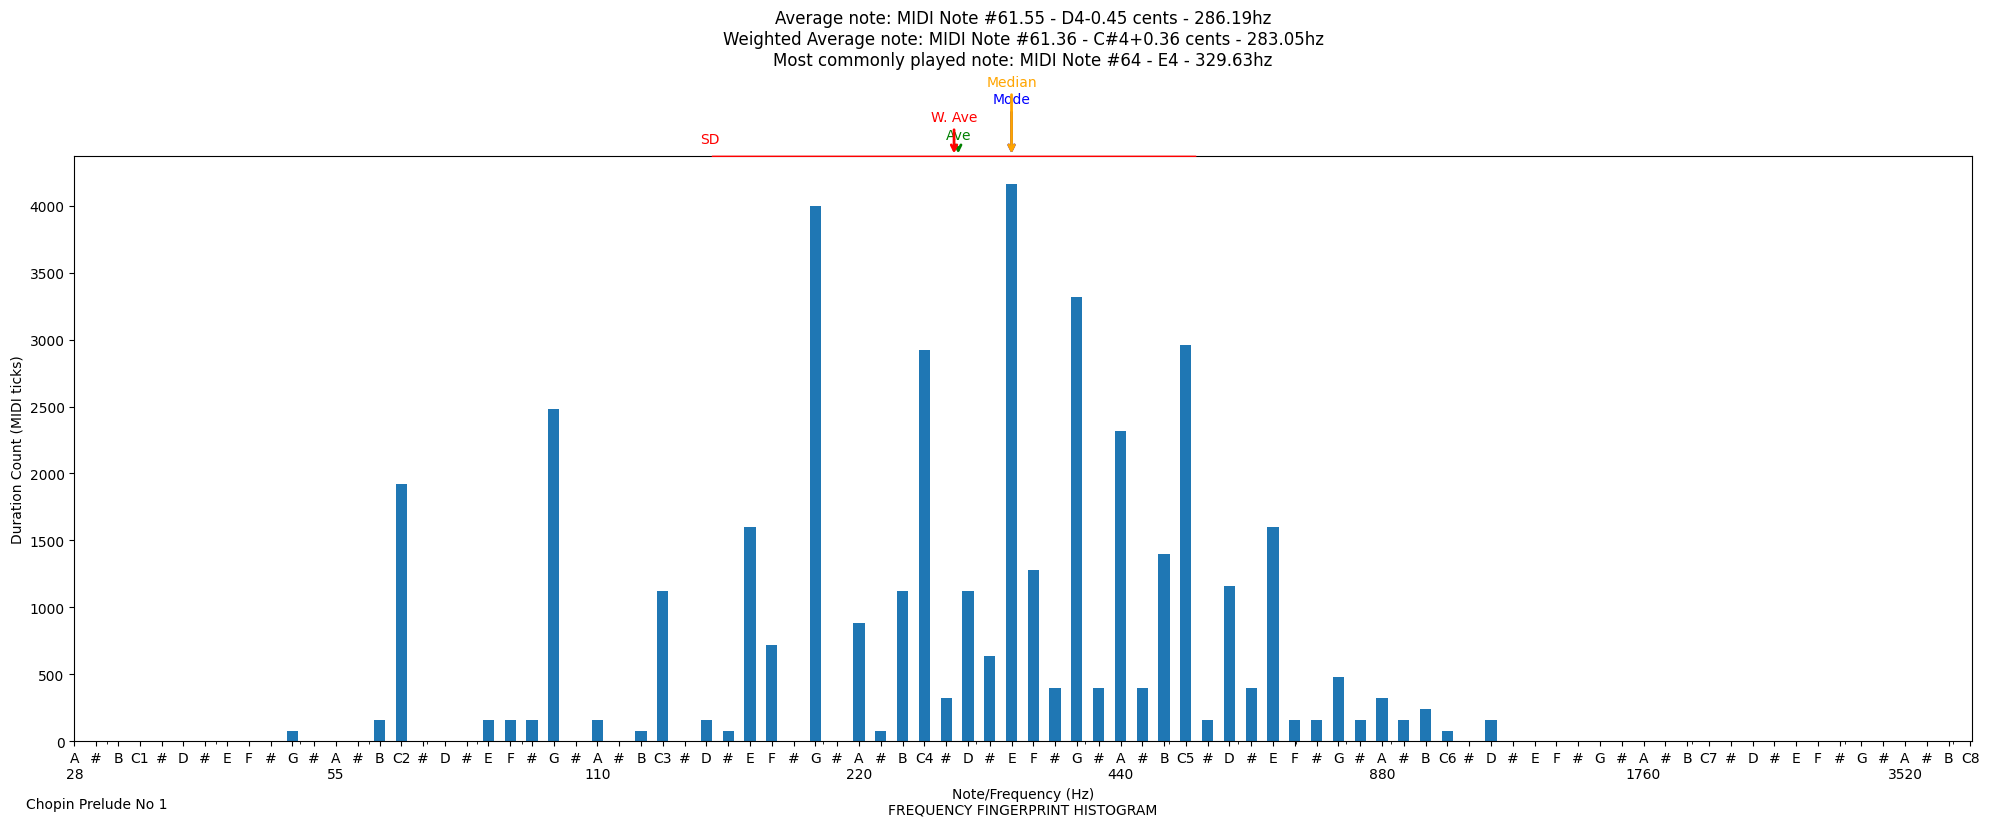

Button(description='Process and Play', style=ButtonStyle())

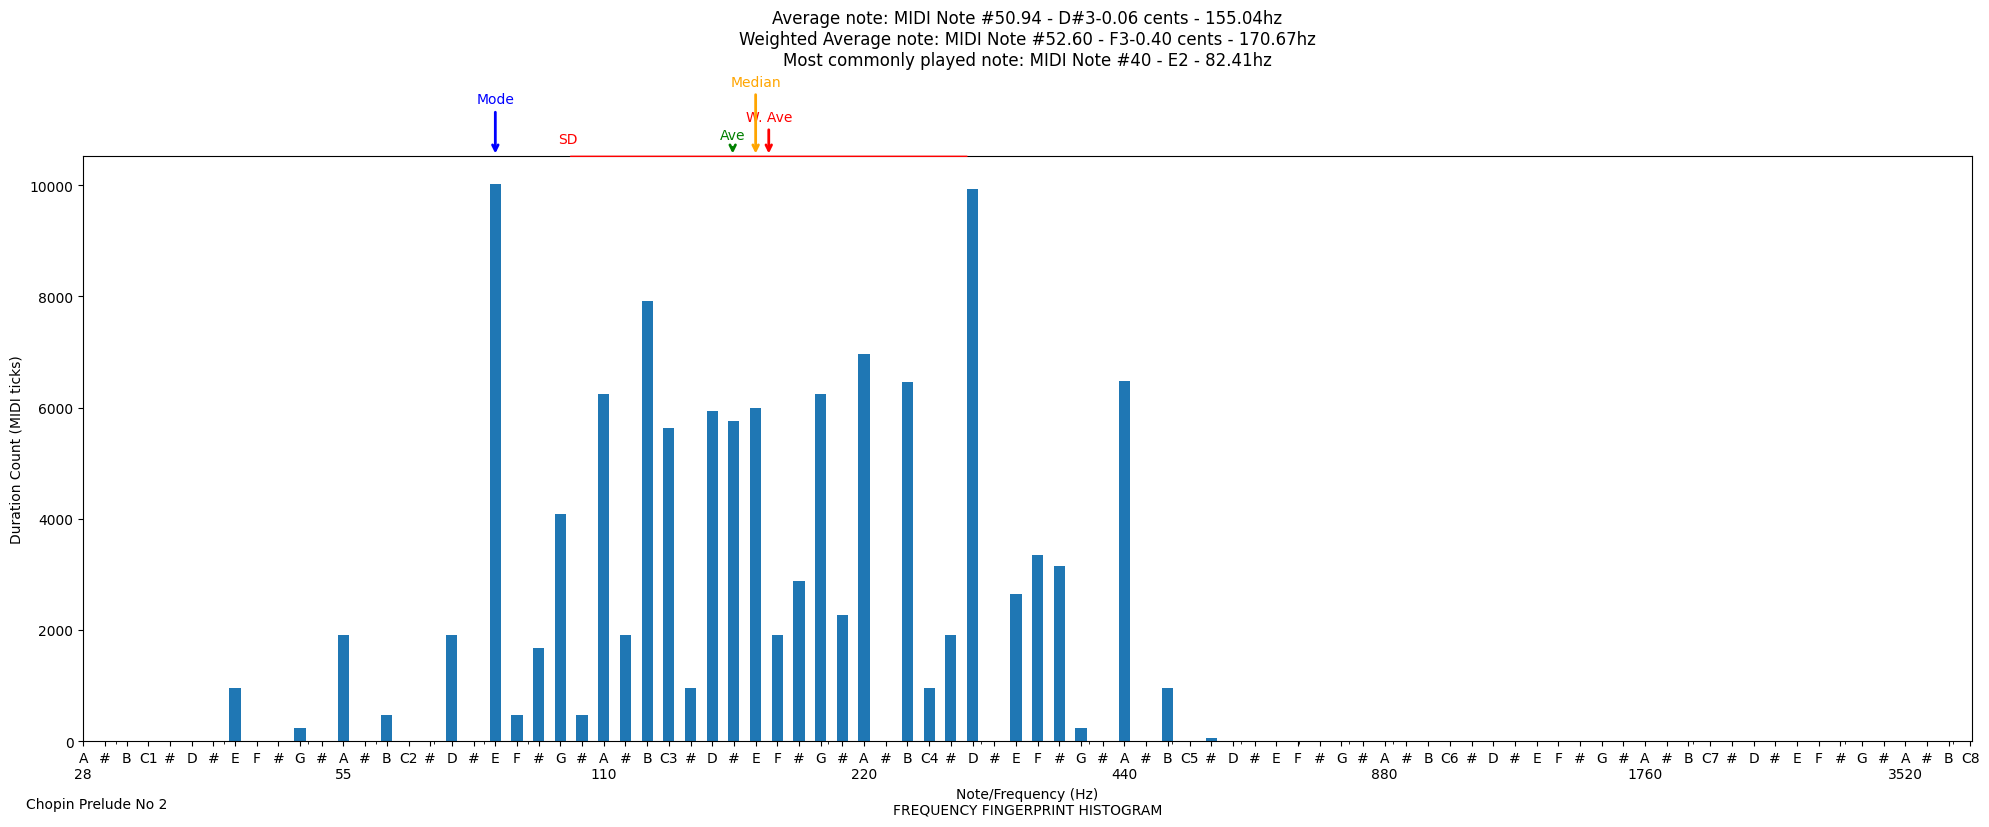

Button(description='Process and Play', style=ButtonStyle())

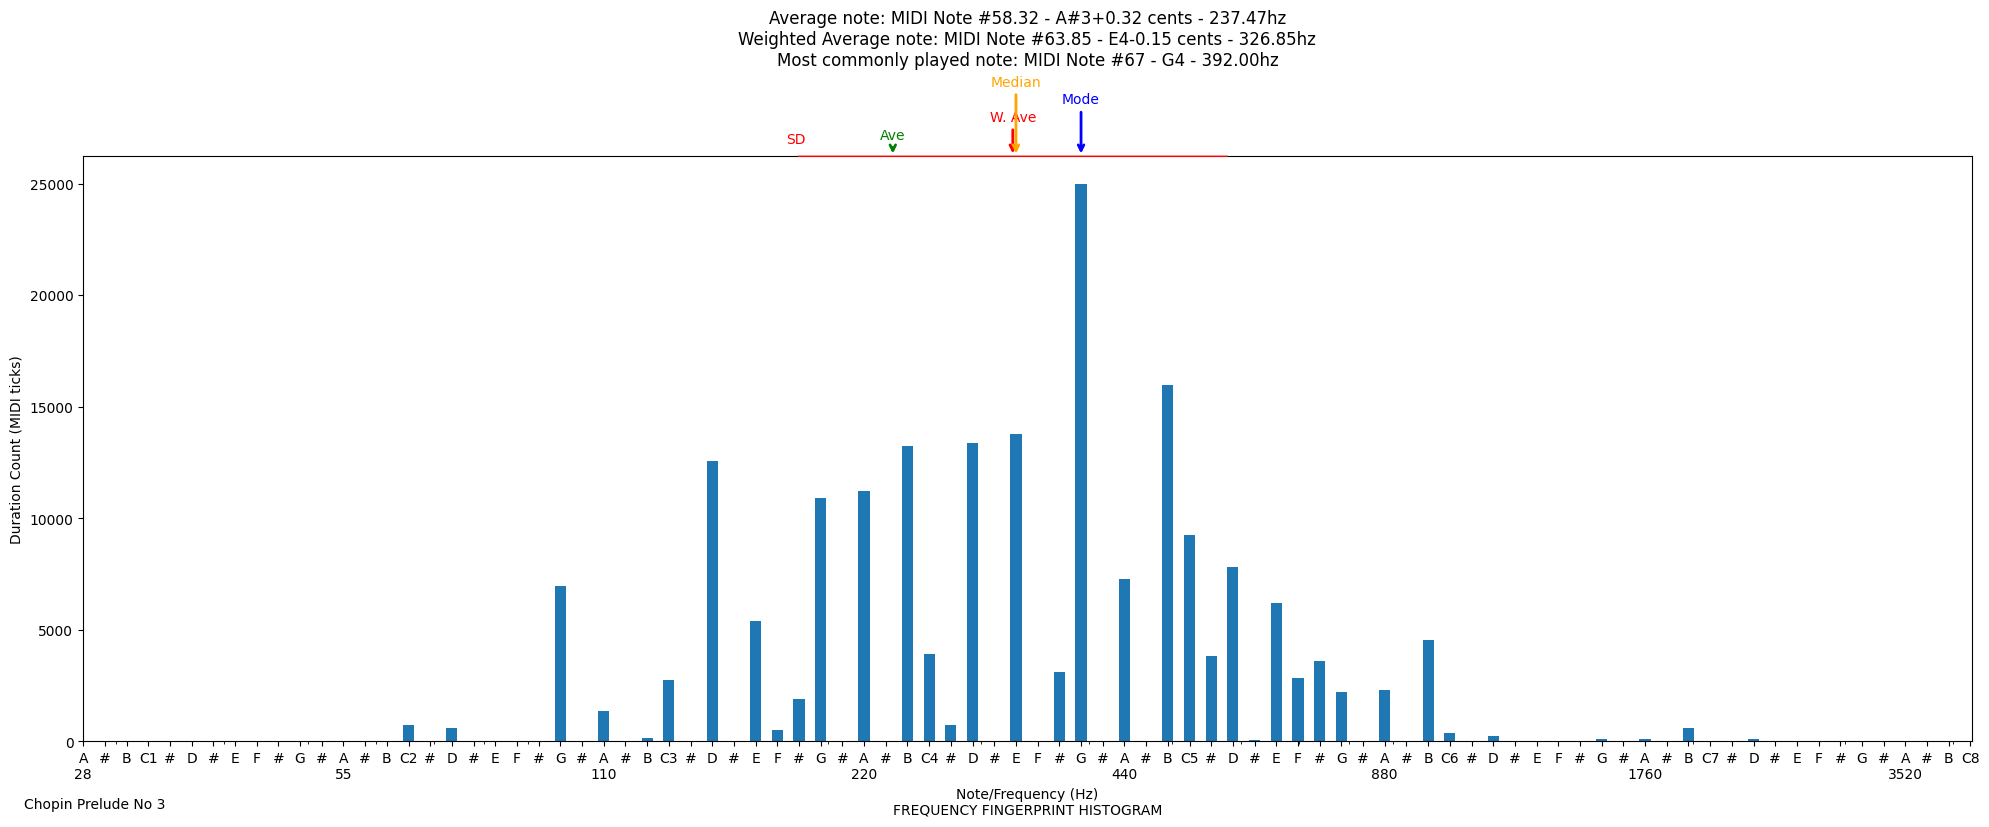

Button(description='Process and Play', style=ButtonStyle())

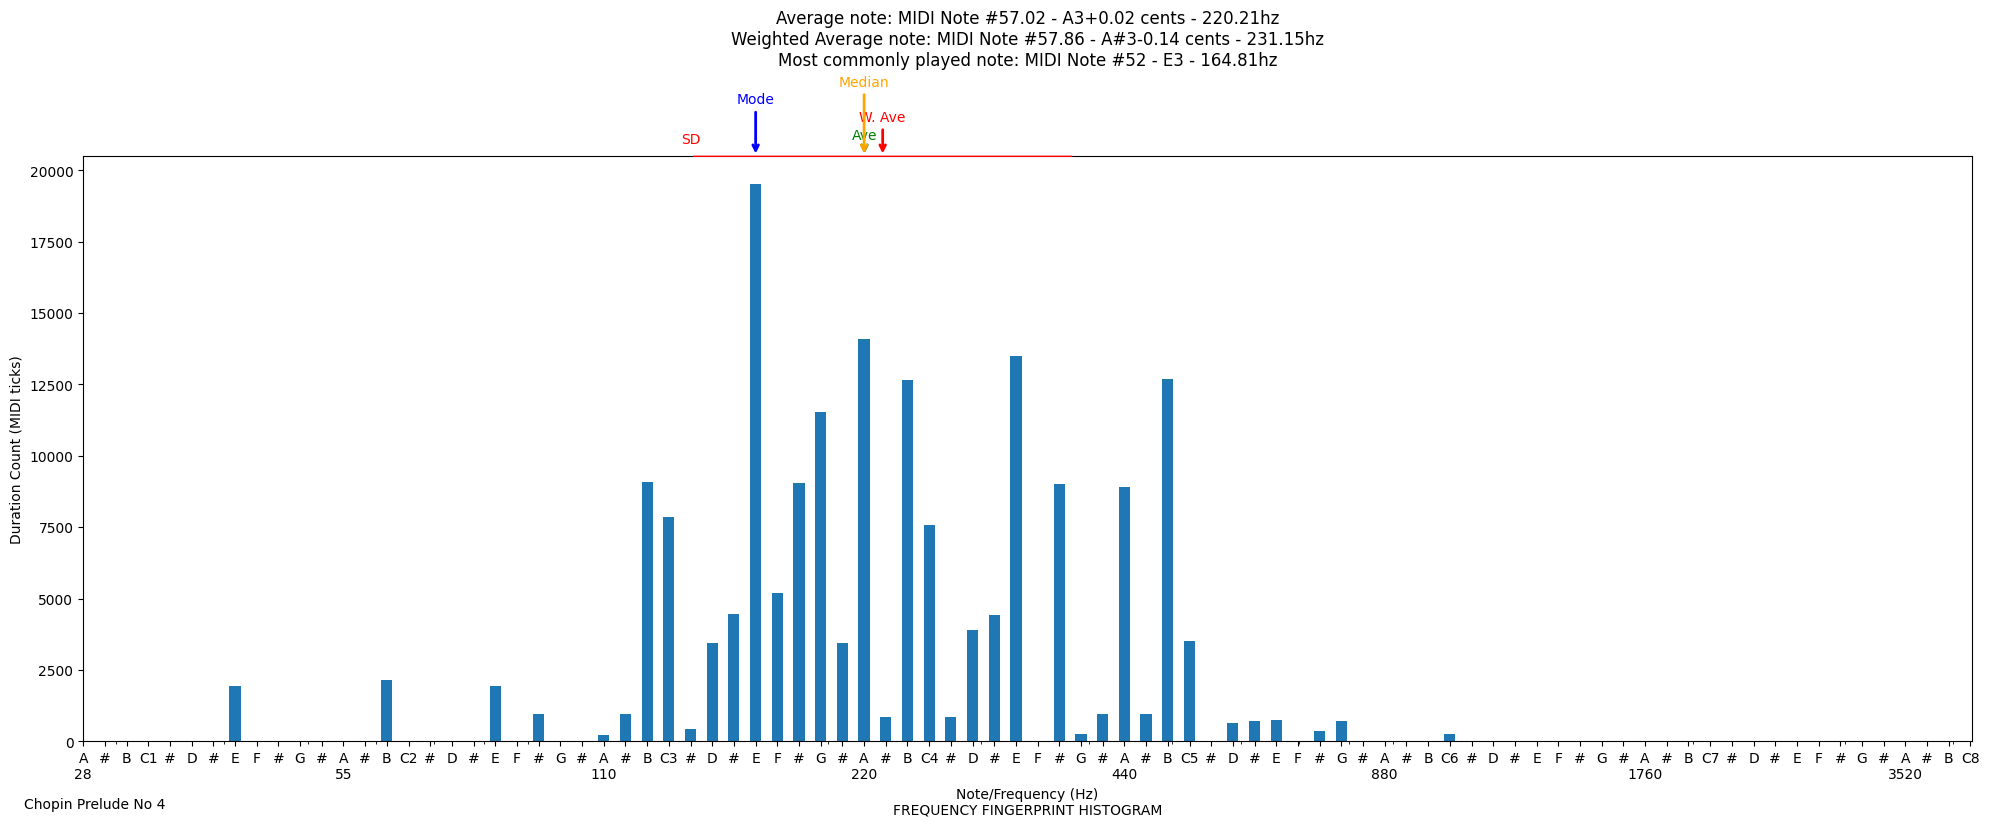

Button(description='Process and Play', style=ButtonStyle())

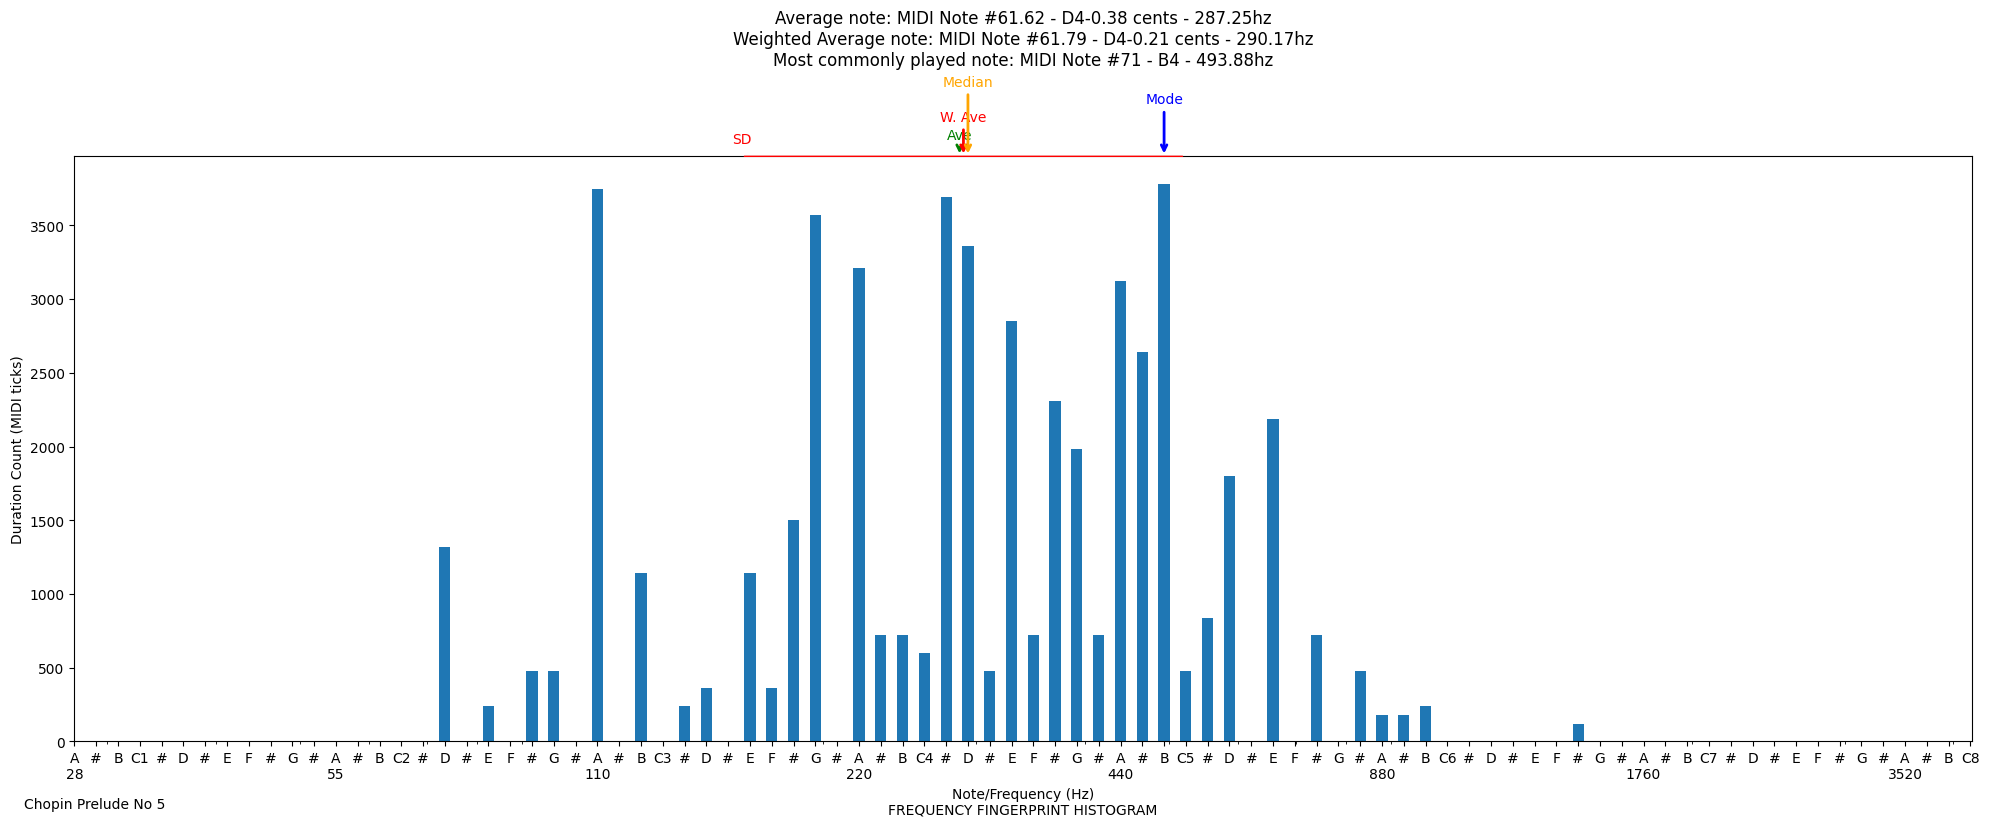

Button(description='Process and Play', style=ButtonStyle())

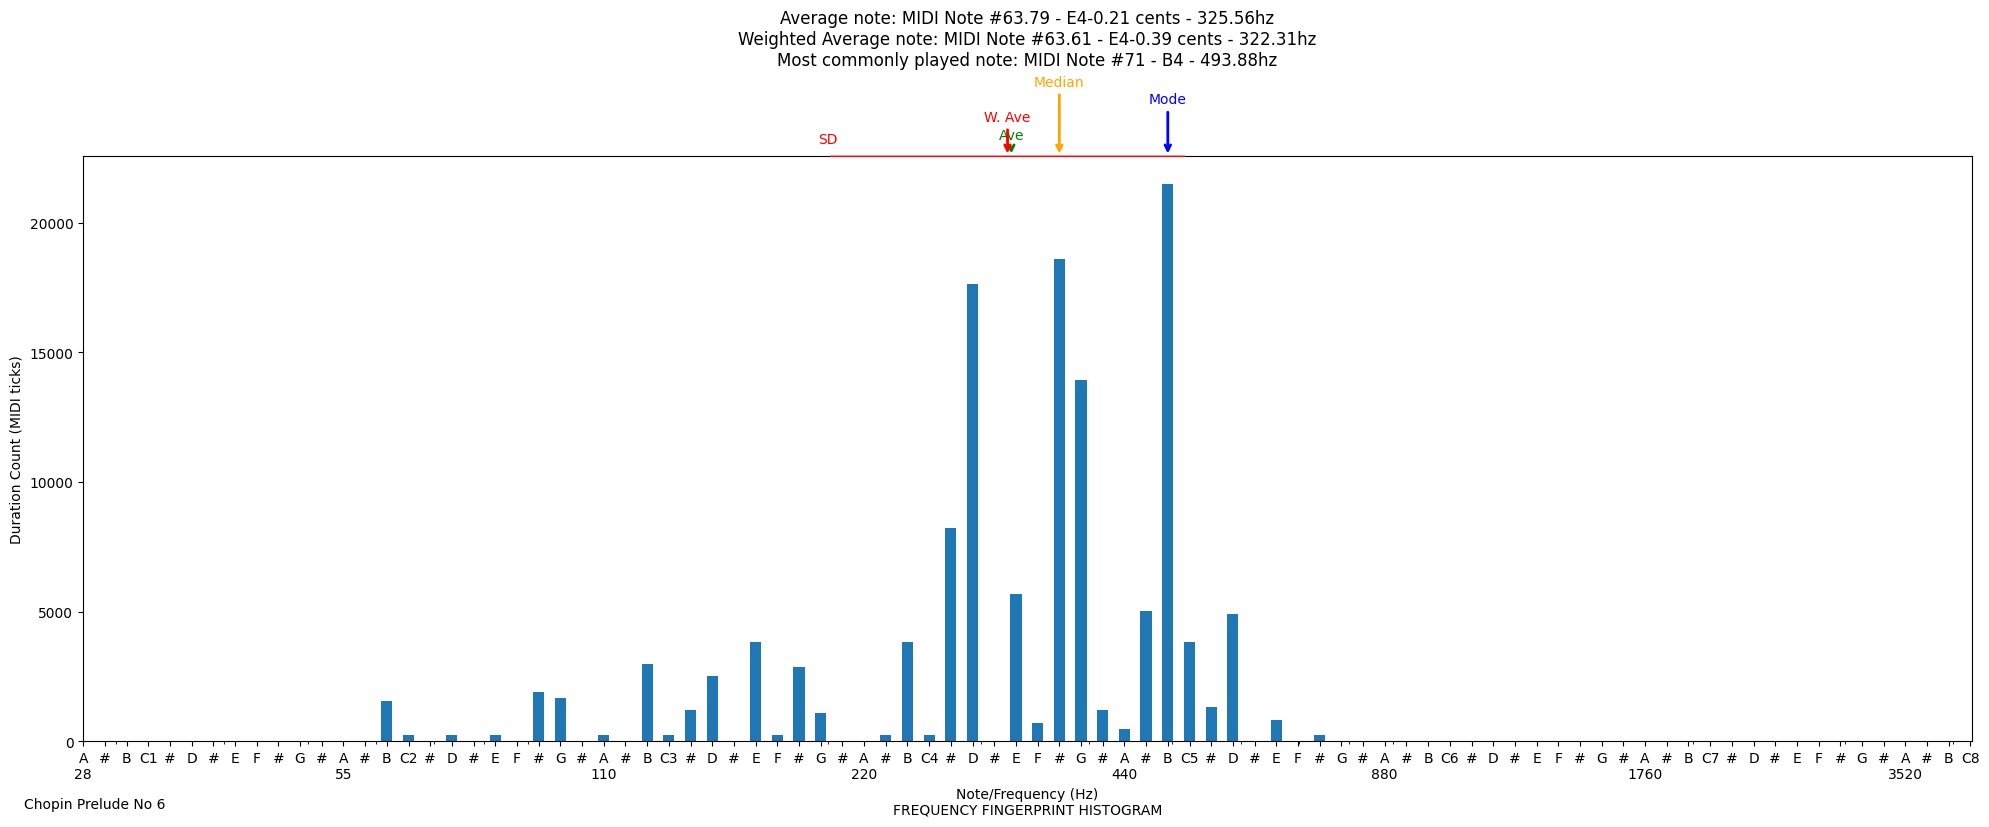

Button(description='Process and Play', style=ButtonStyle())

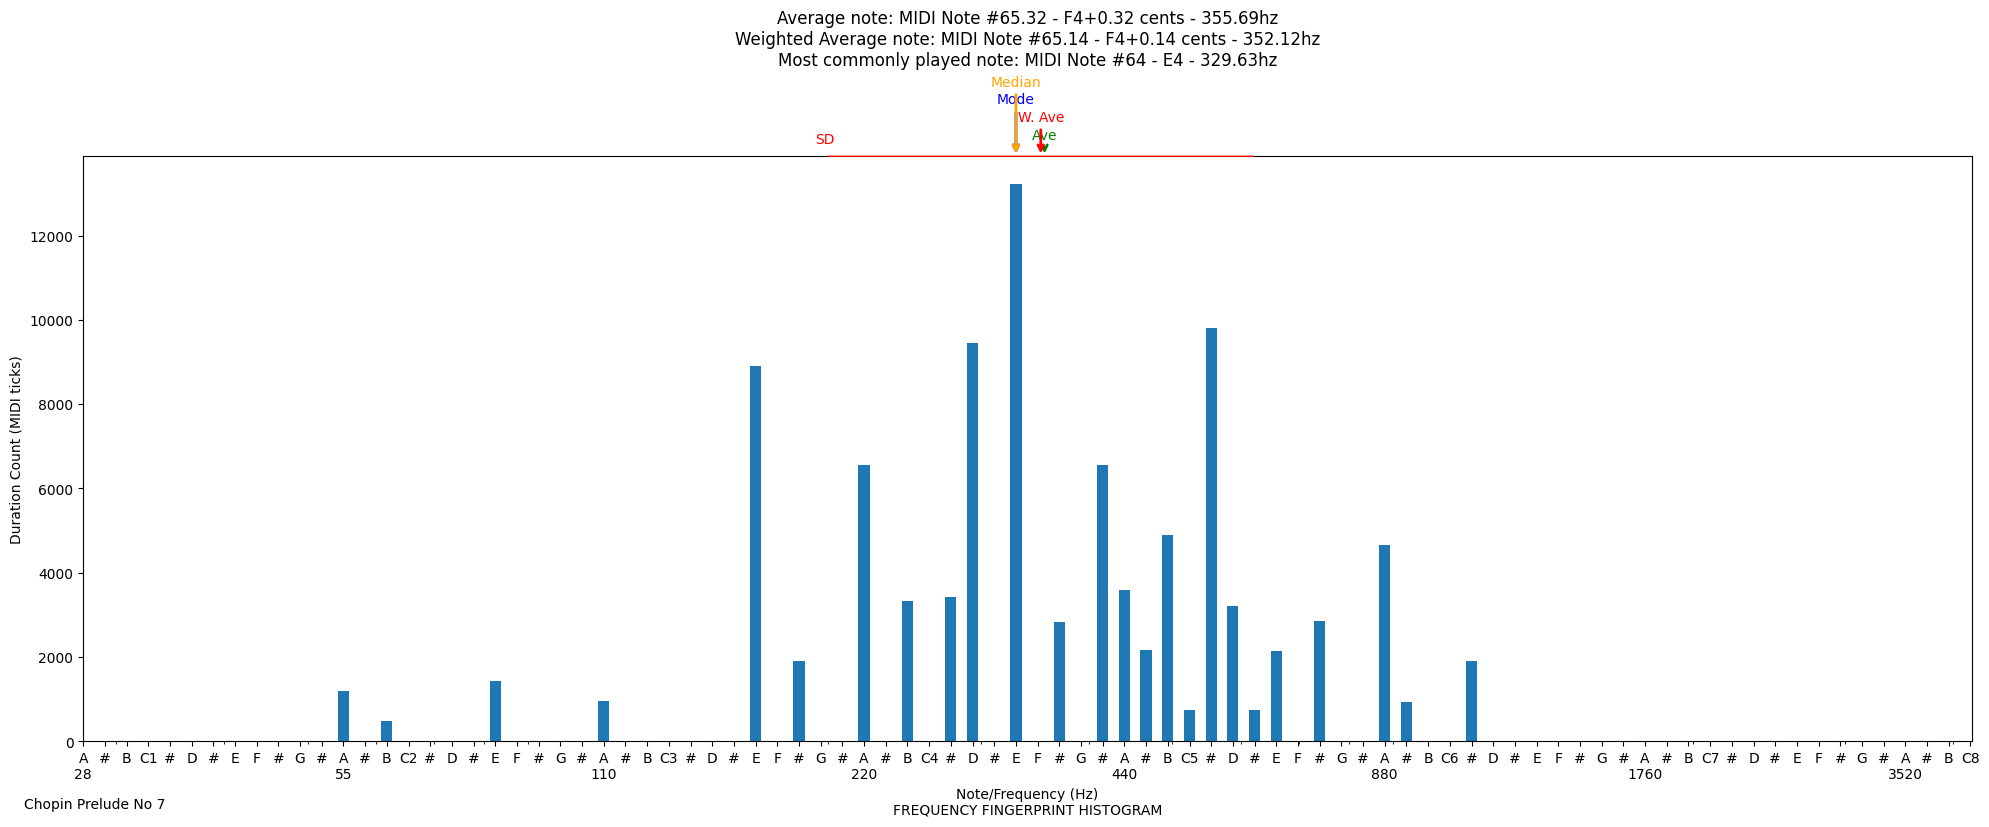

Button(description='Process and Play', style=ButtonStyle())

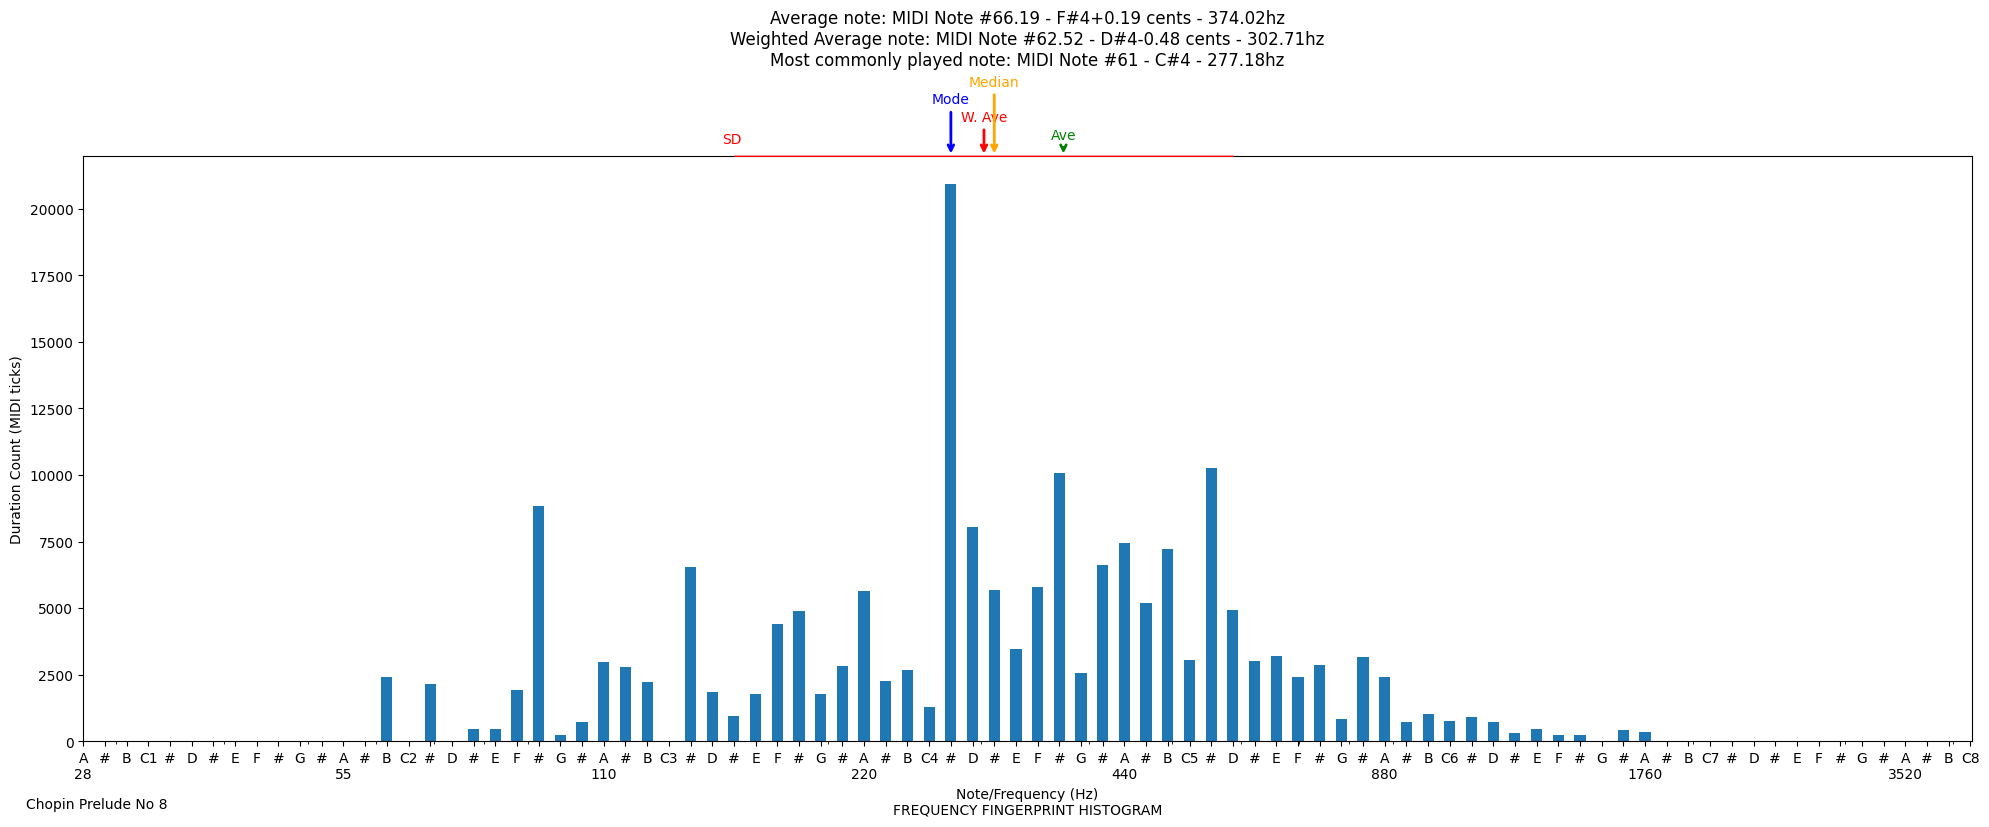

Button(description='Process and Play', style=ButtonStyle())

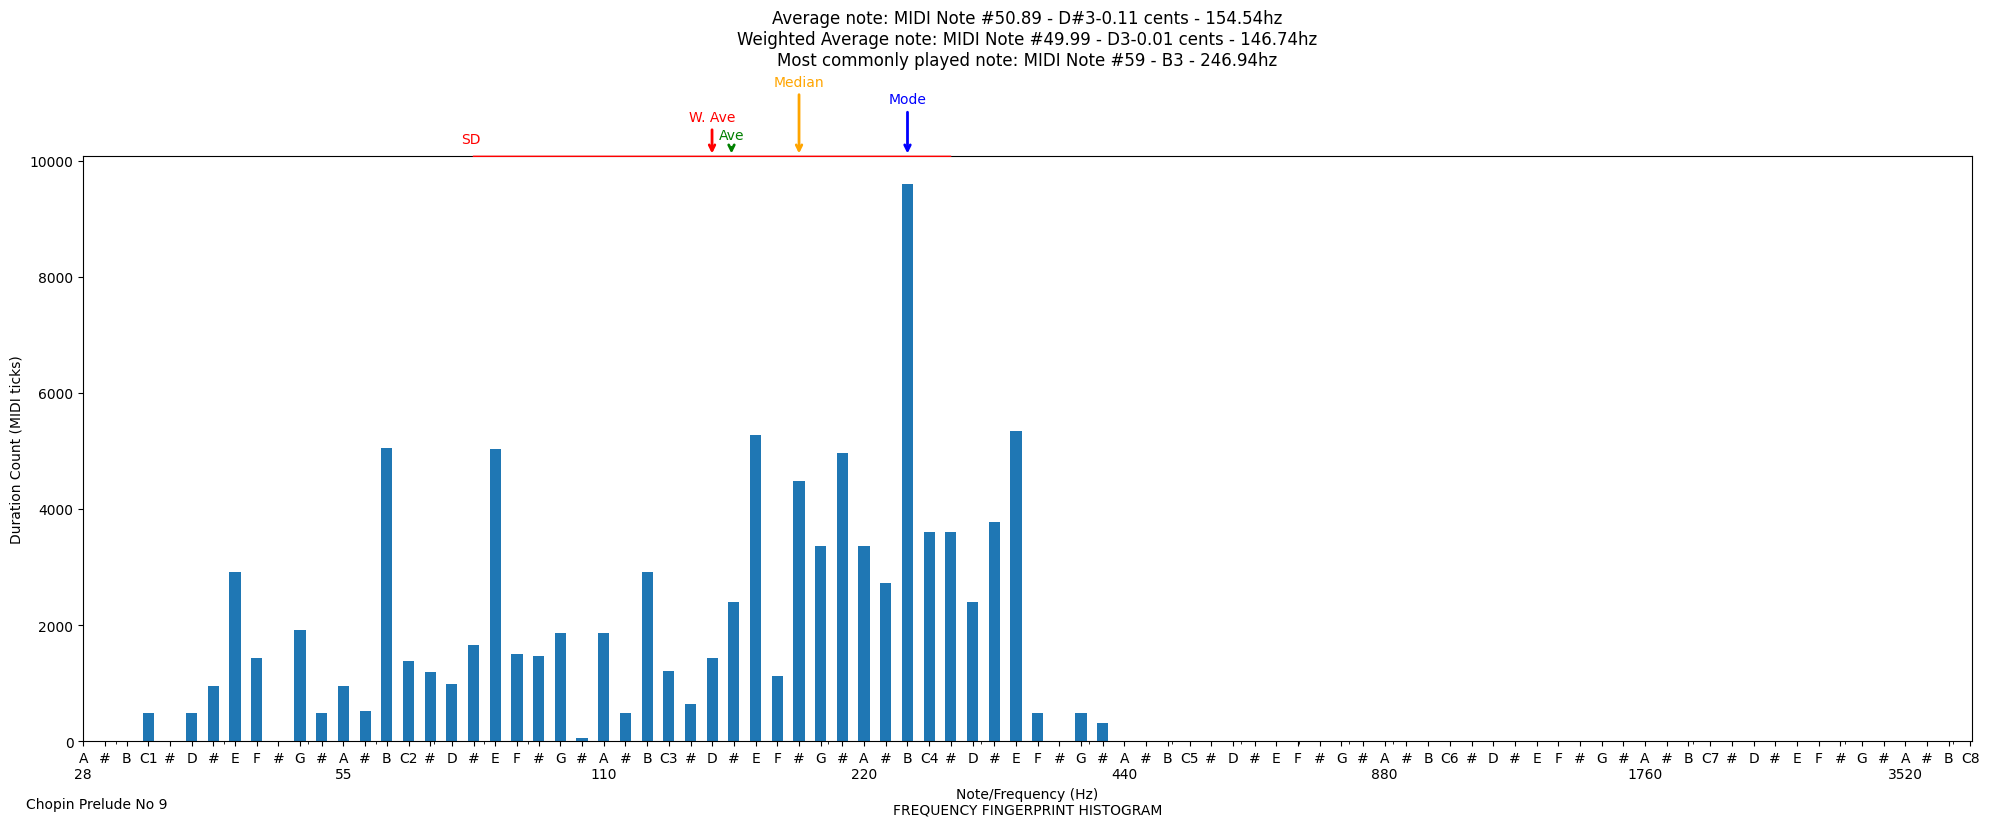

Button(description='Process and Play', style=ButtonStyle())

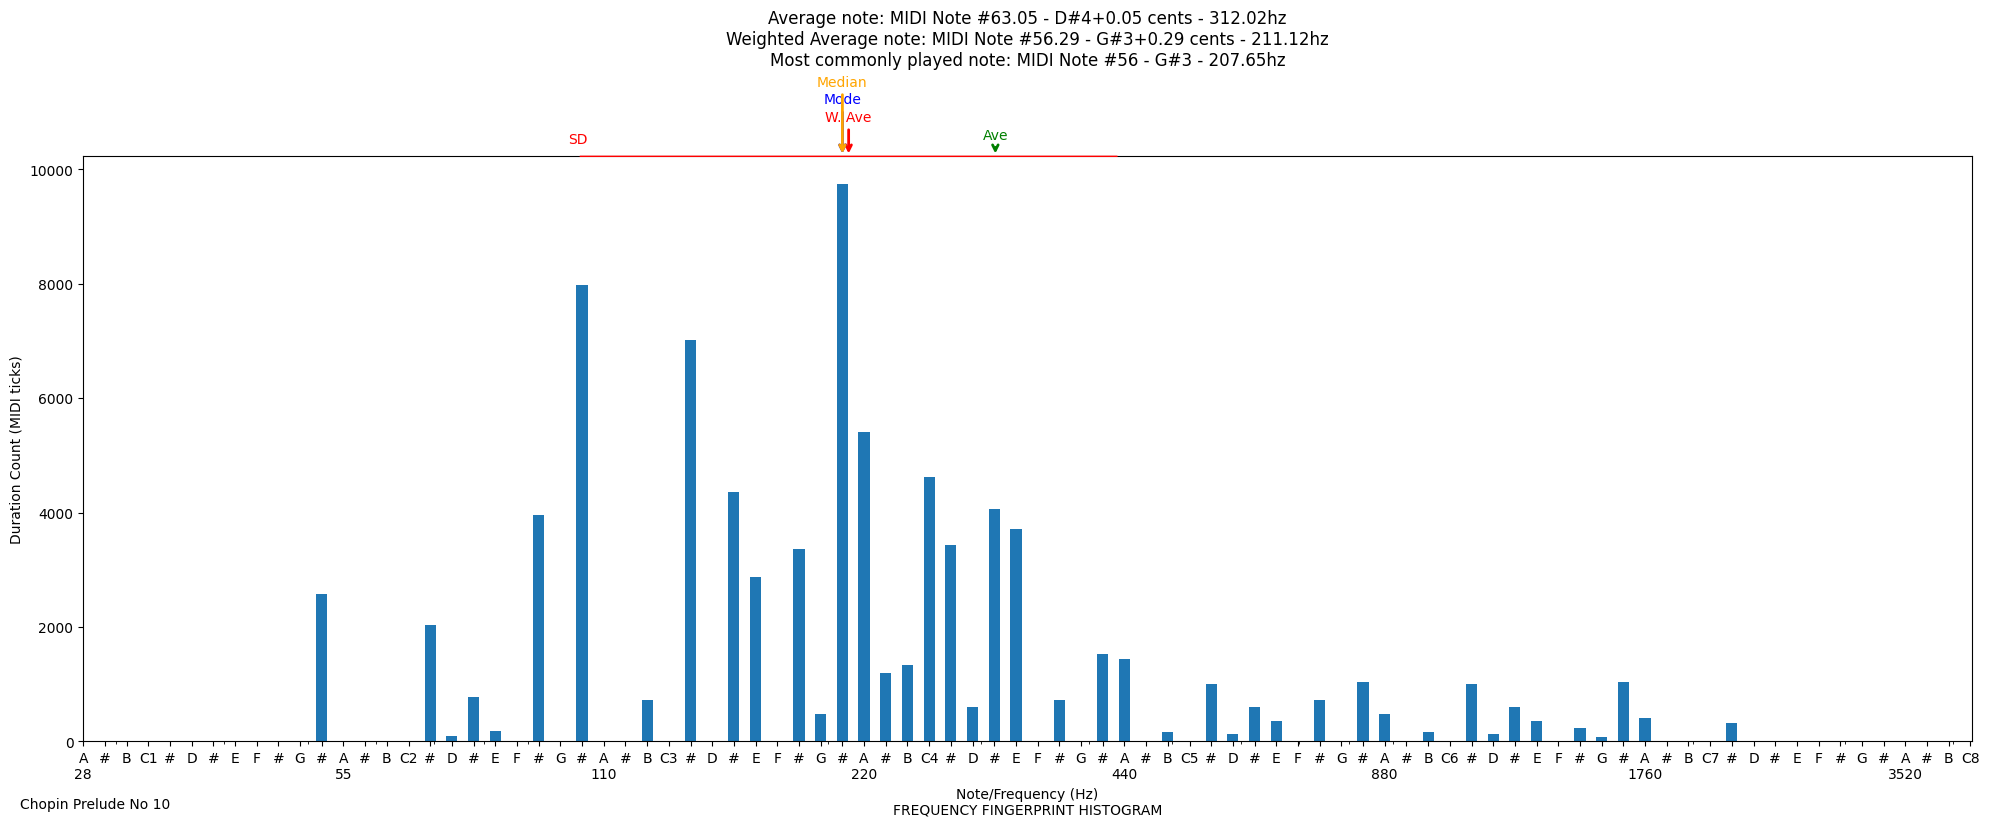

Button(description='Process and Play', style=ButtonStyle())

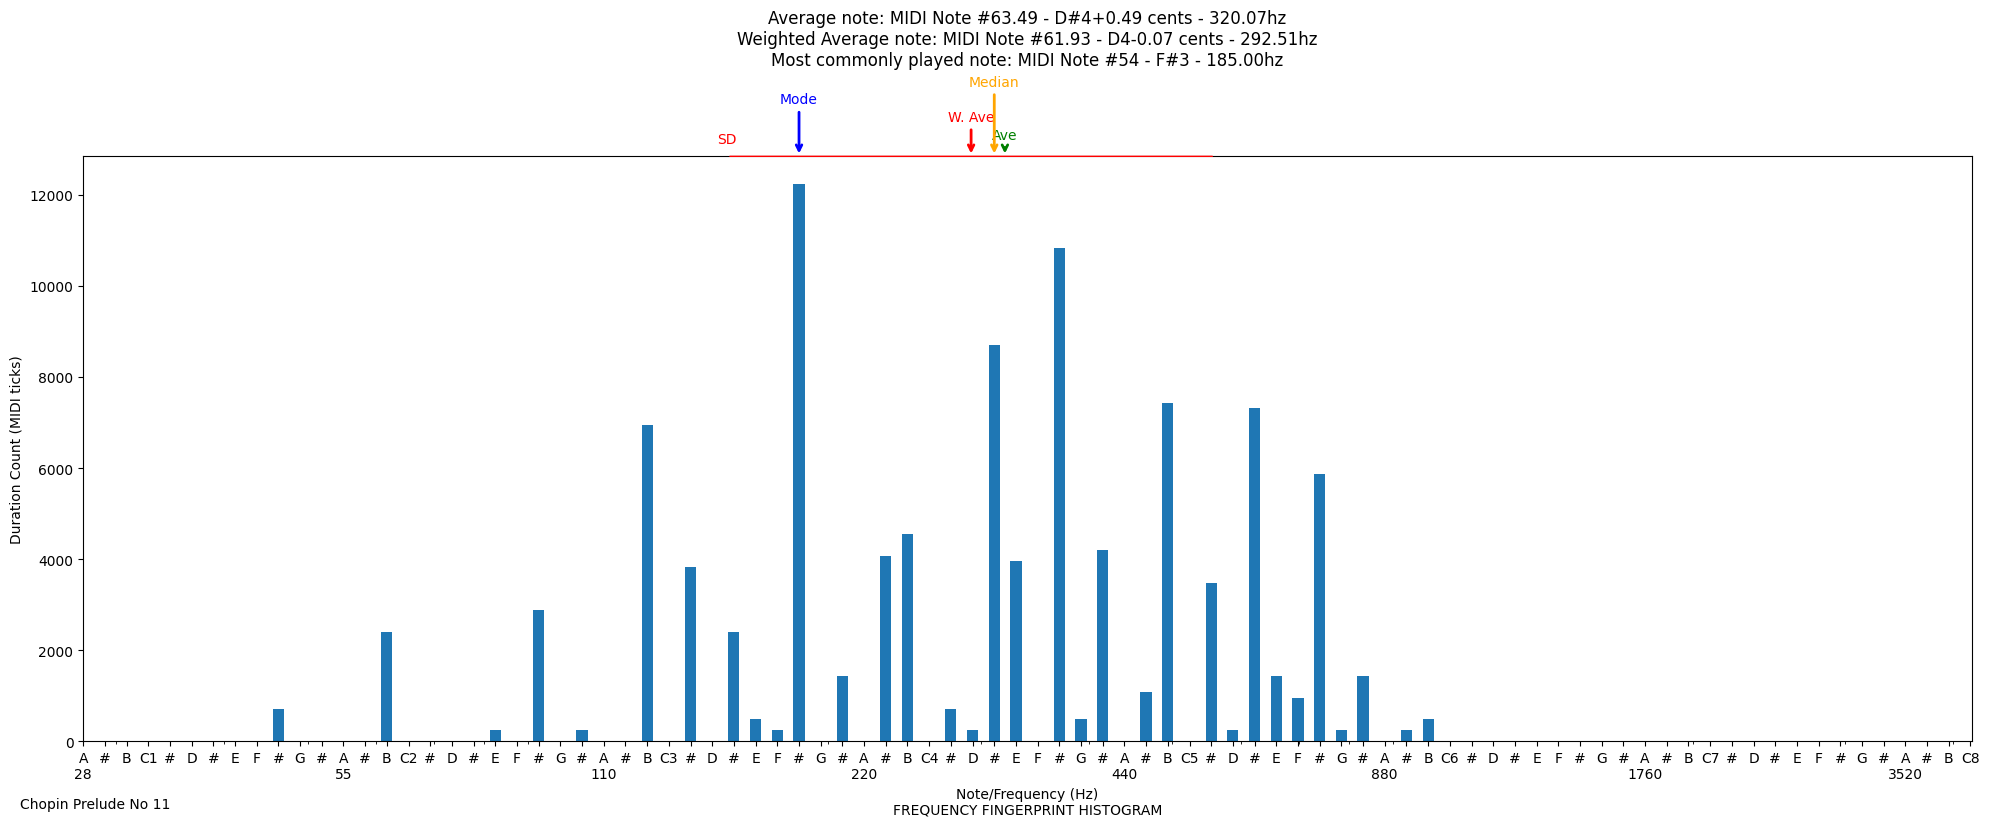

Button(description='Process and Play', style=ButtonStyle())

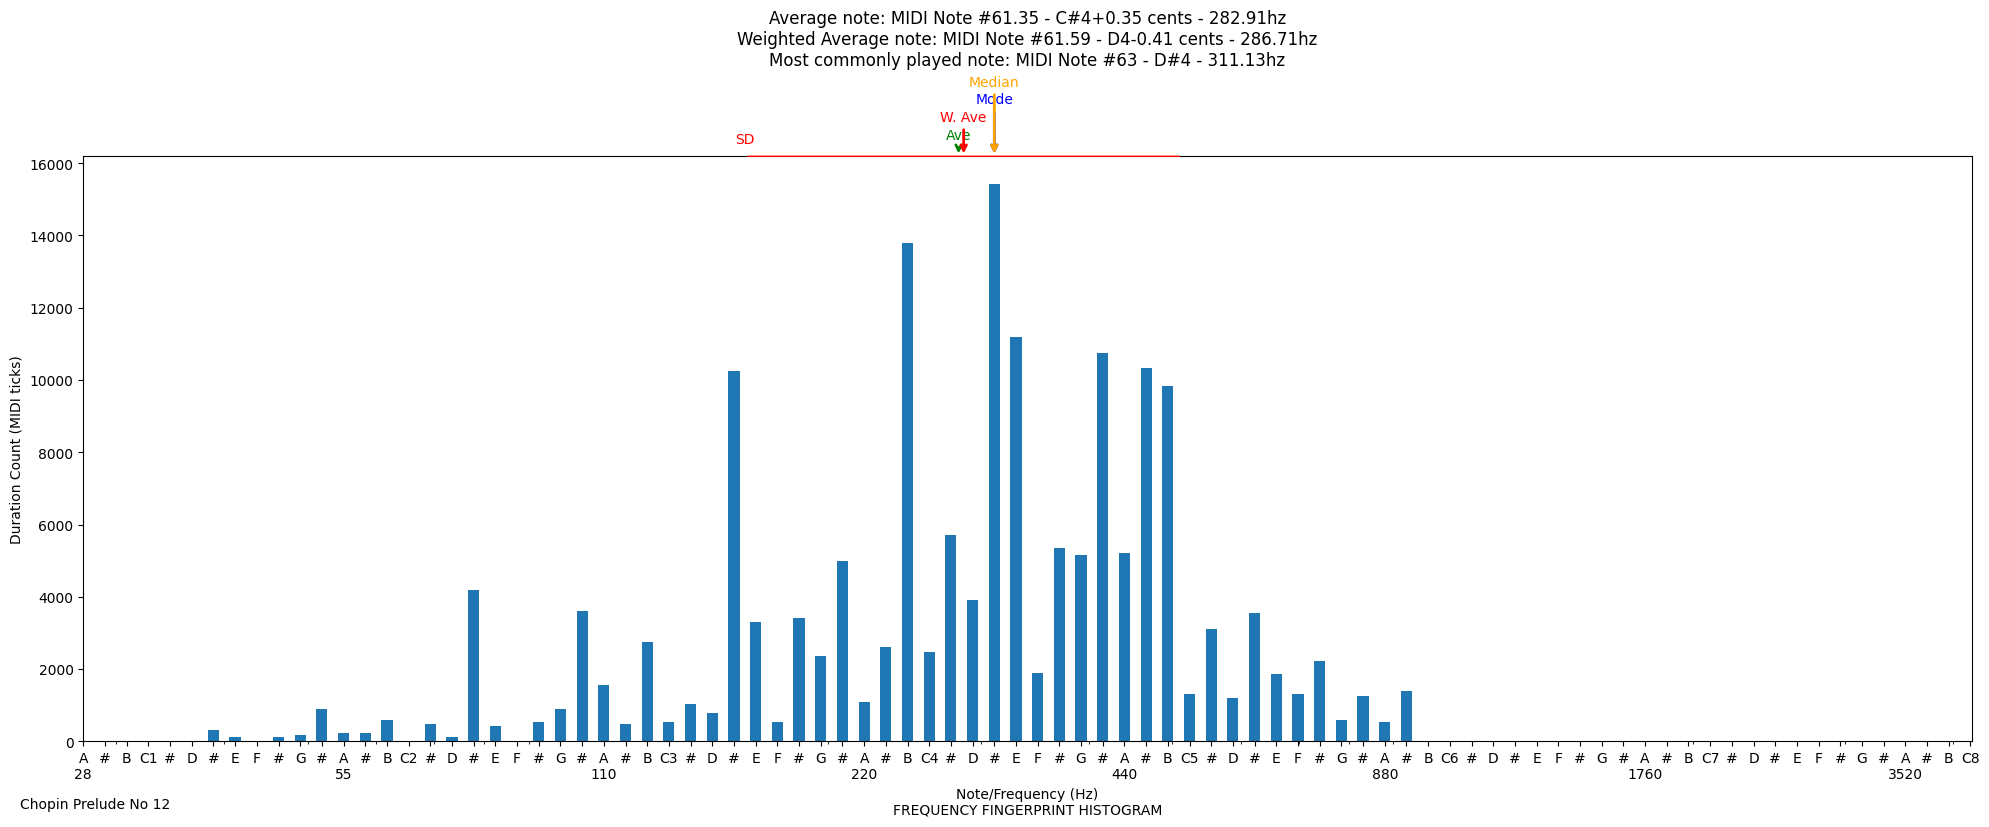

Button(description='Process and Play', style=ButtonStyle())

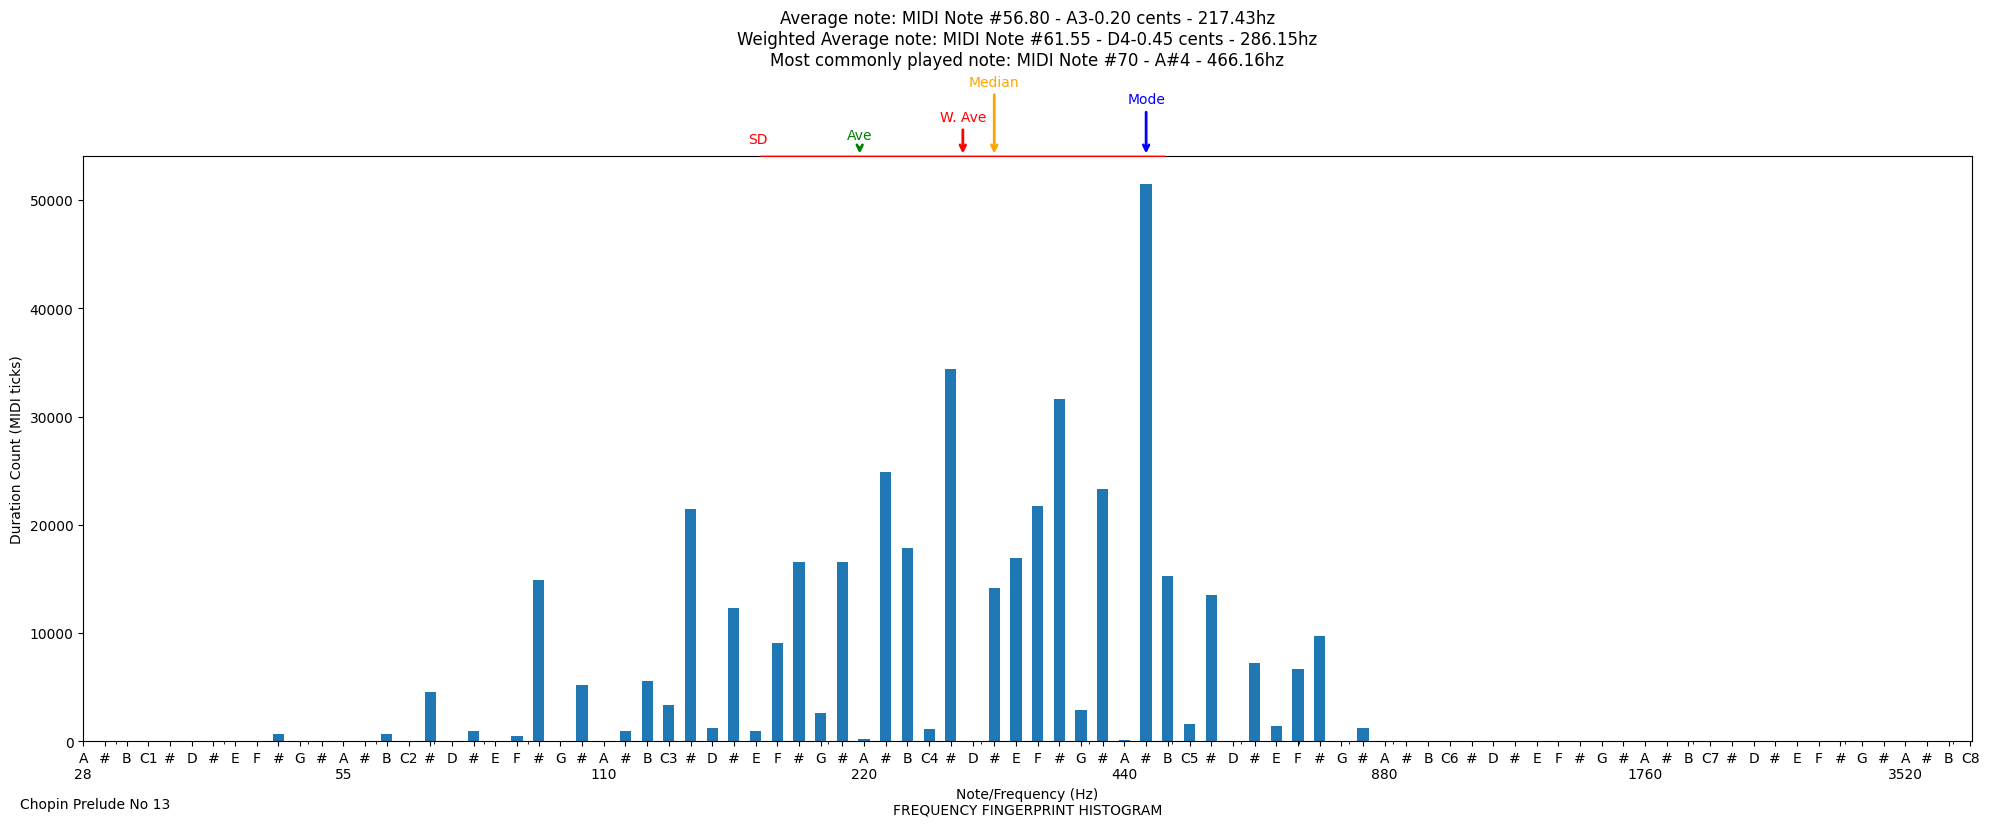

Button(description='Process and Play', style=ButtonStyle())

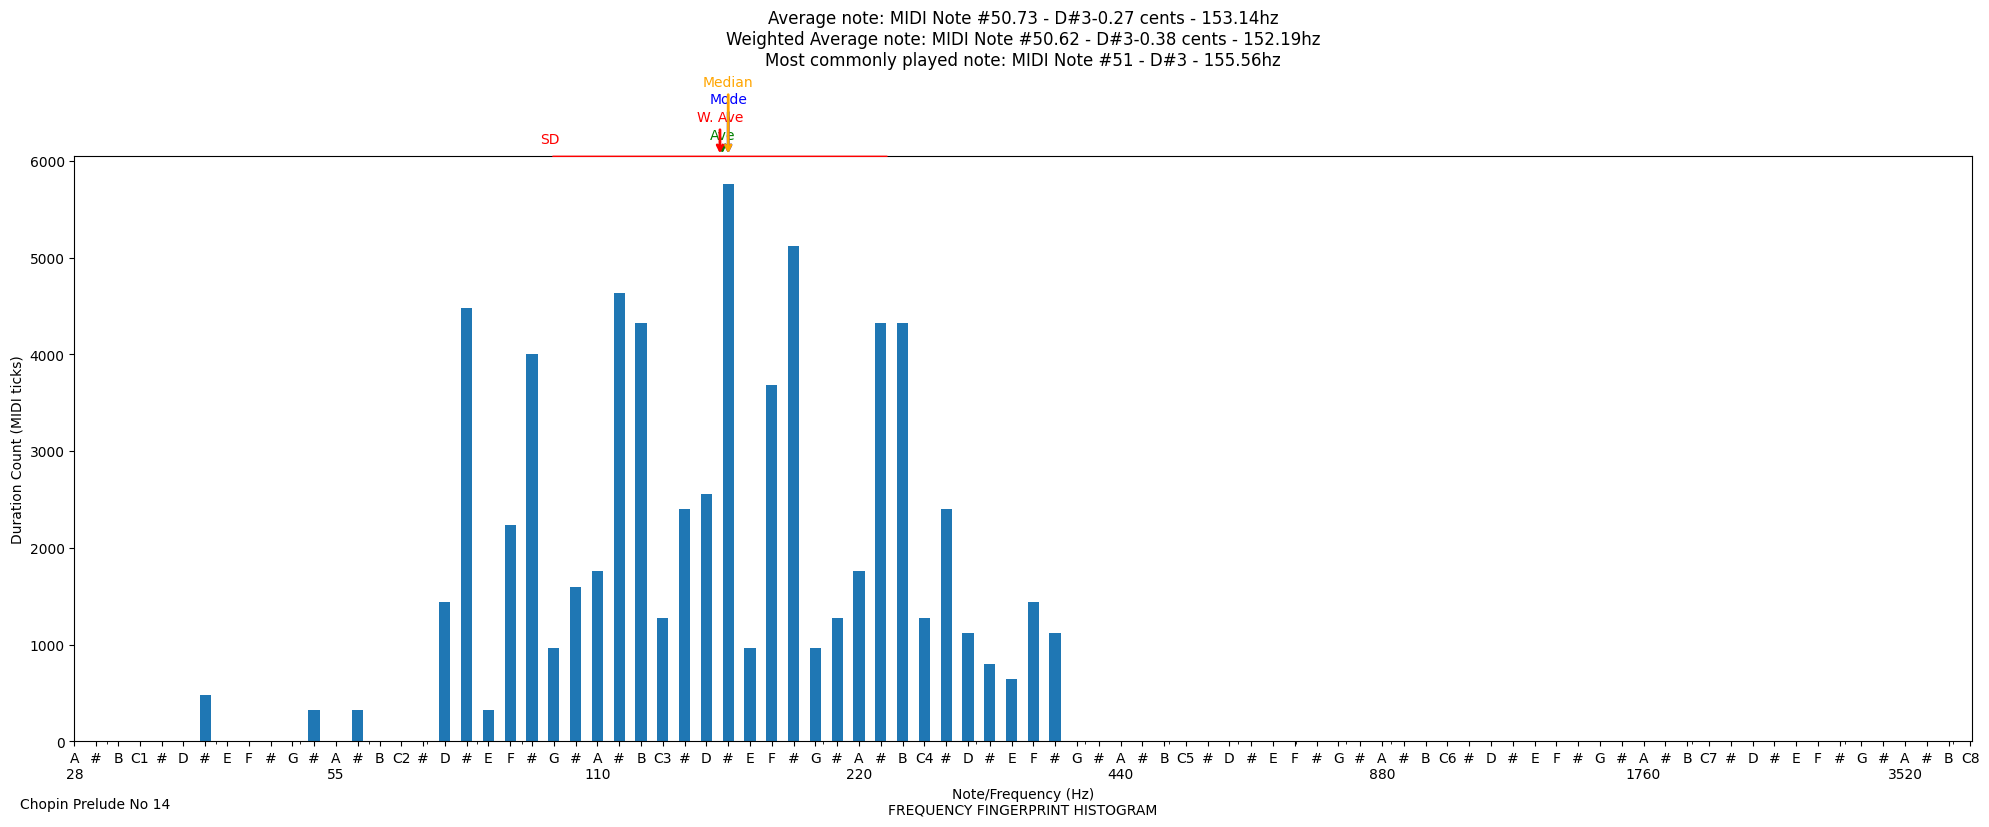

Button(description='Process and Play', style=ButtonStyle())

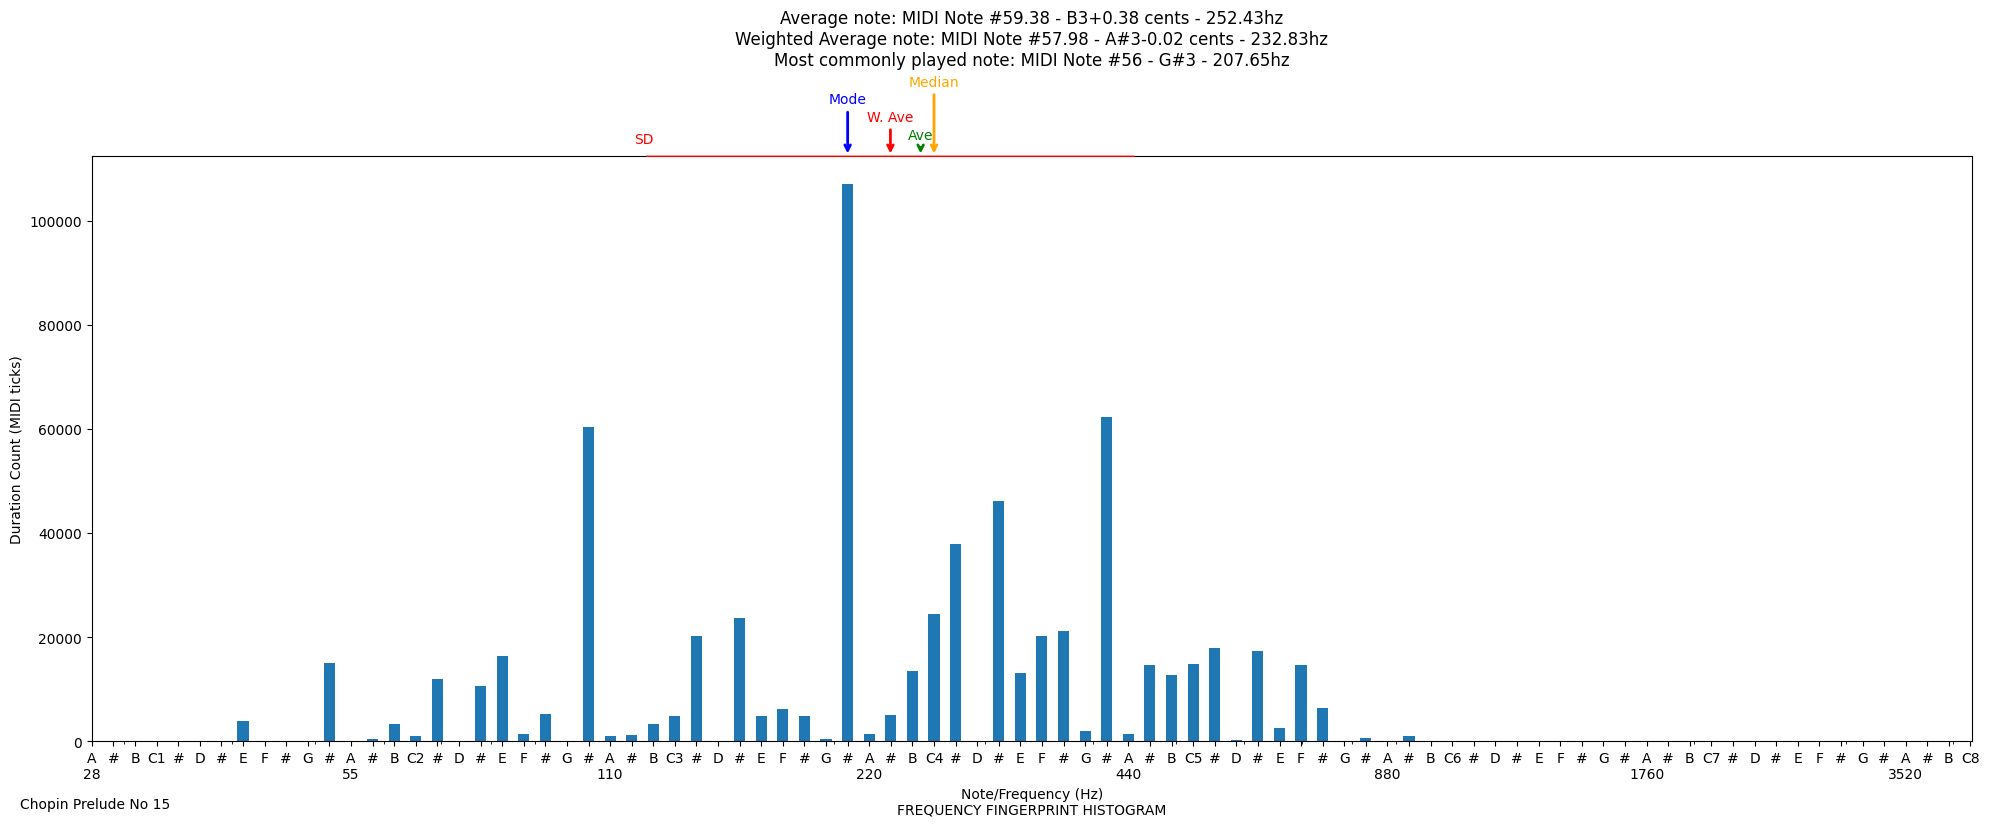

Button(description='Process and Play', style=ButtonStyle())

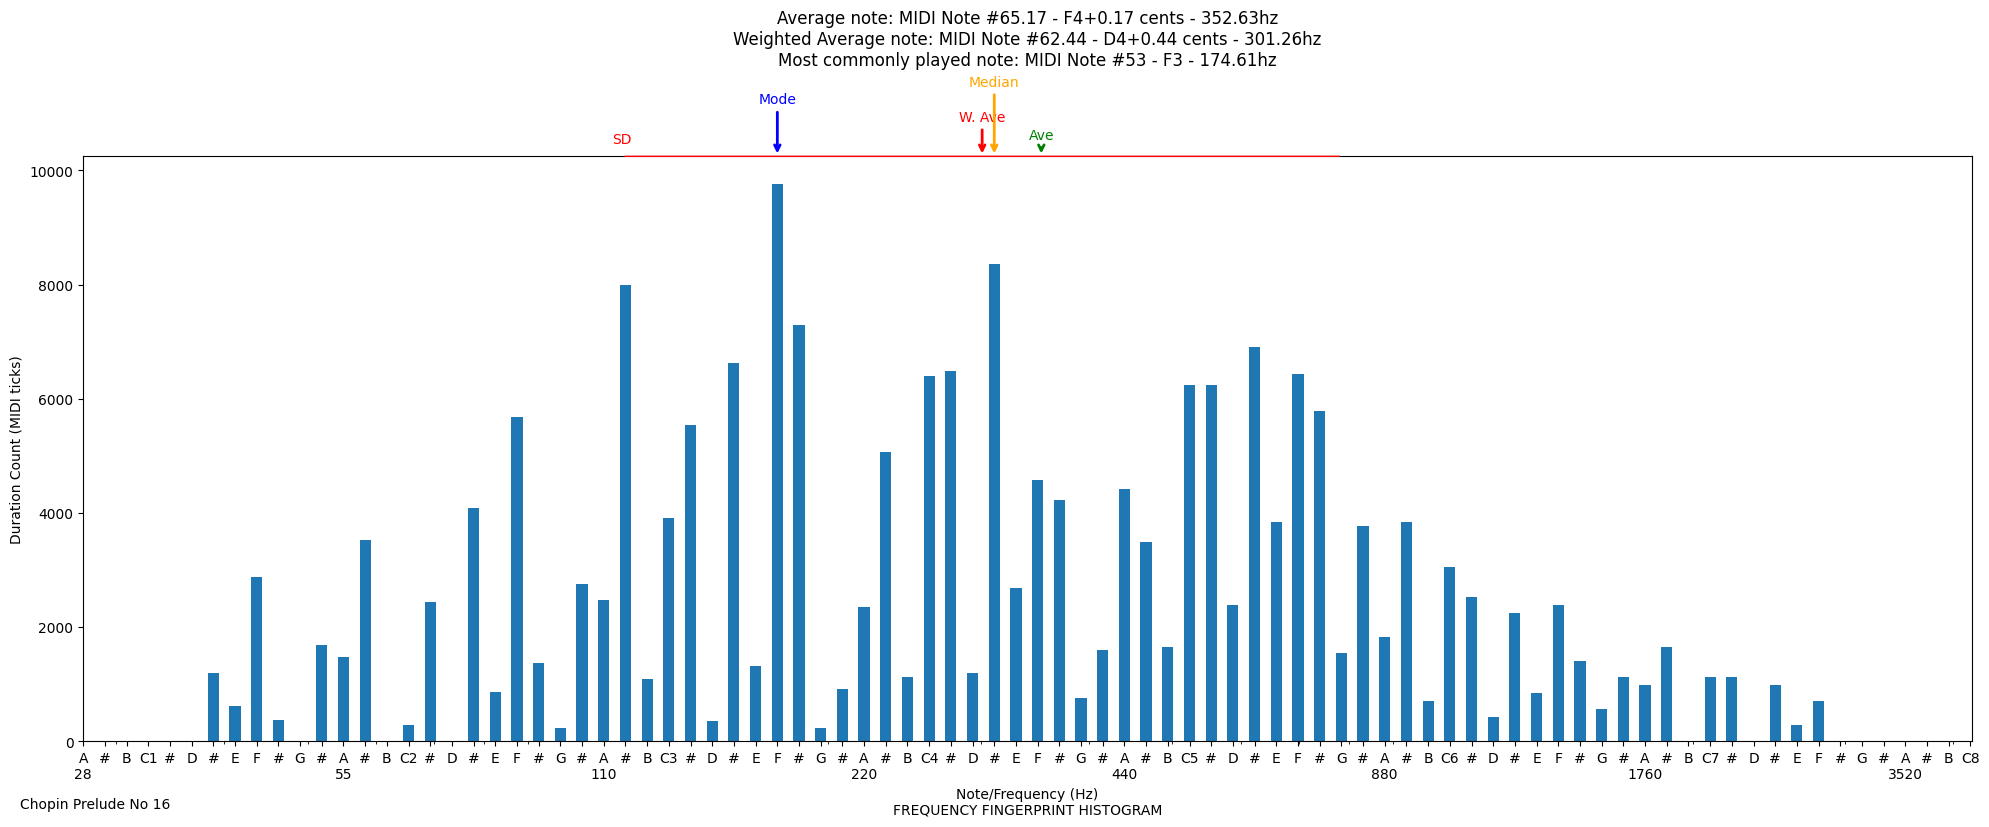

Button(description='Process and Play', style=ButtonStyle())

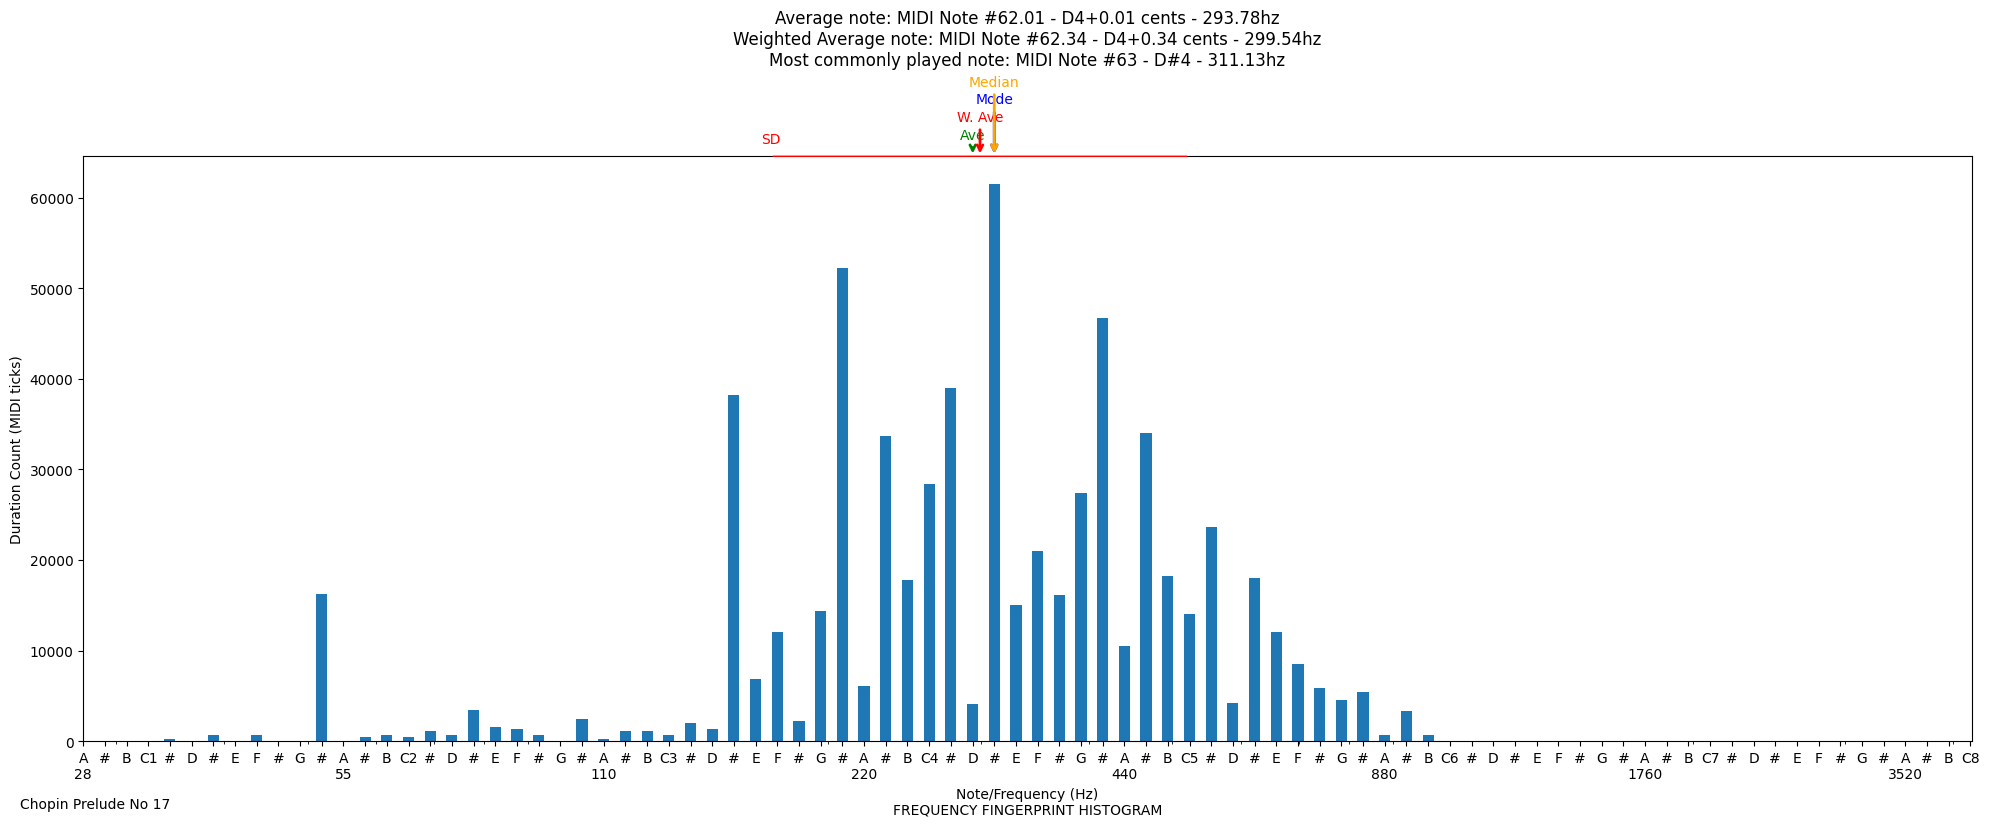

Button(description='Process and Play', style=ButtonStyle())

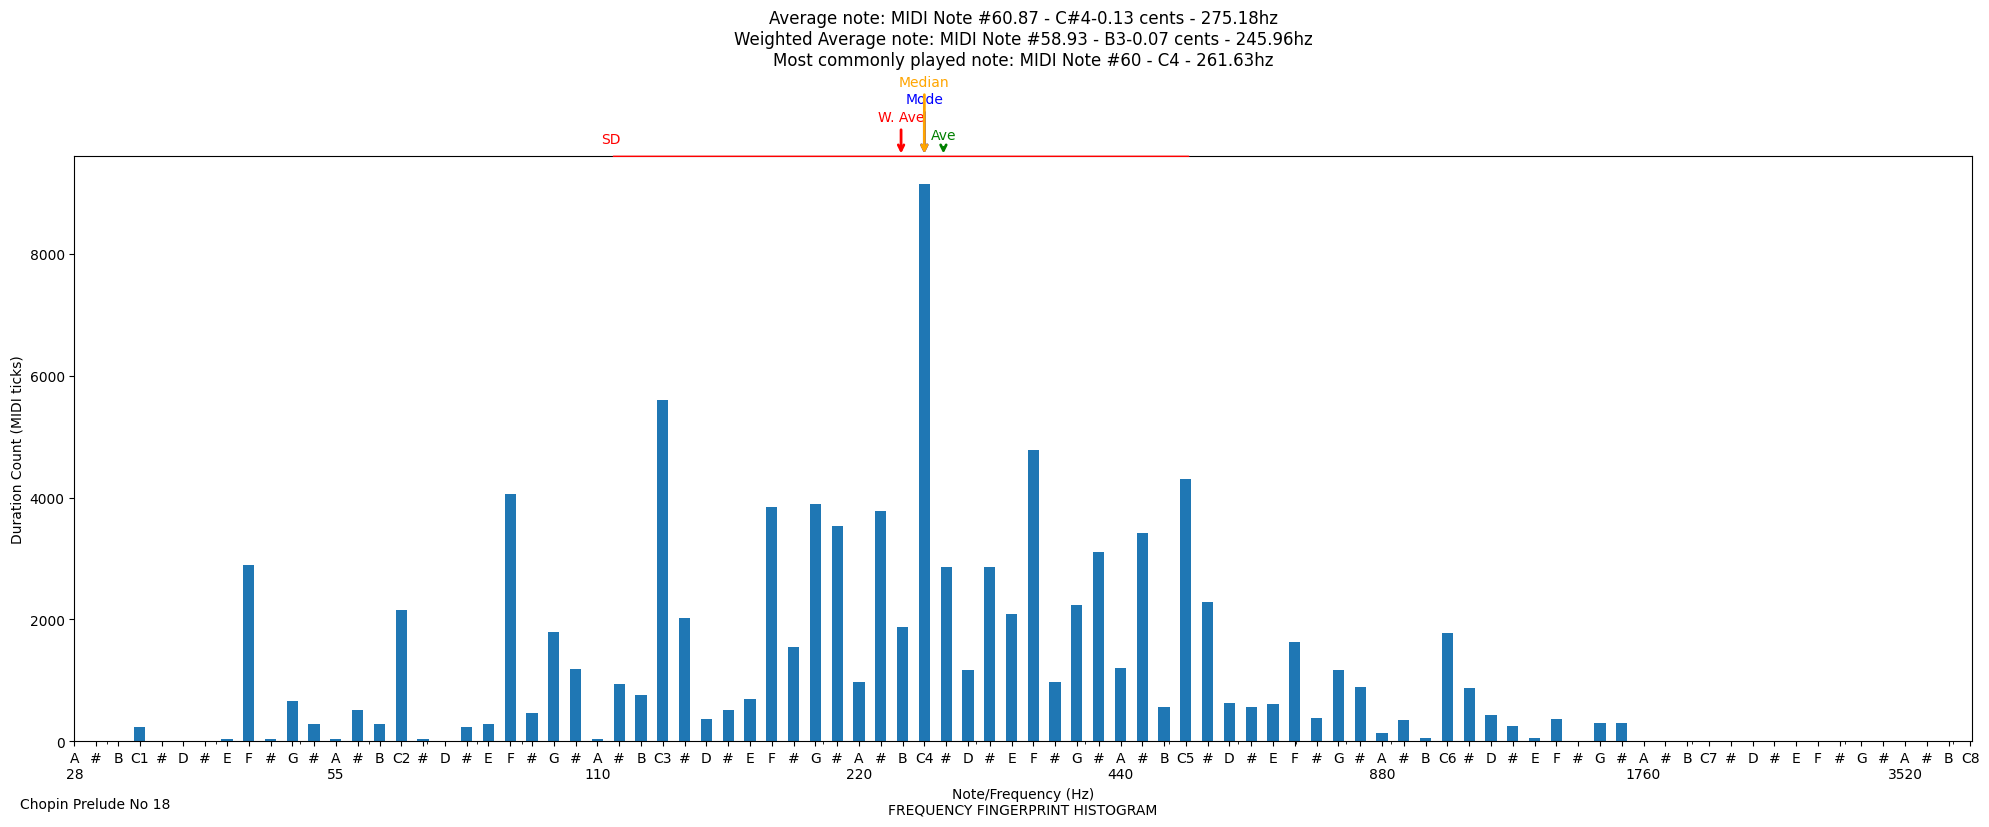

Button(description='Process and Play', style=ButtonStyle())

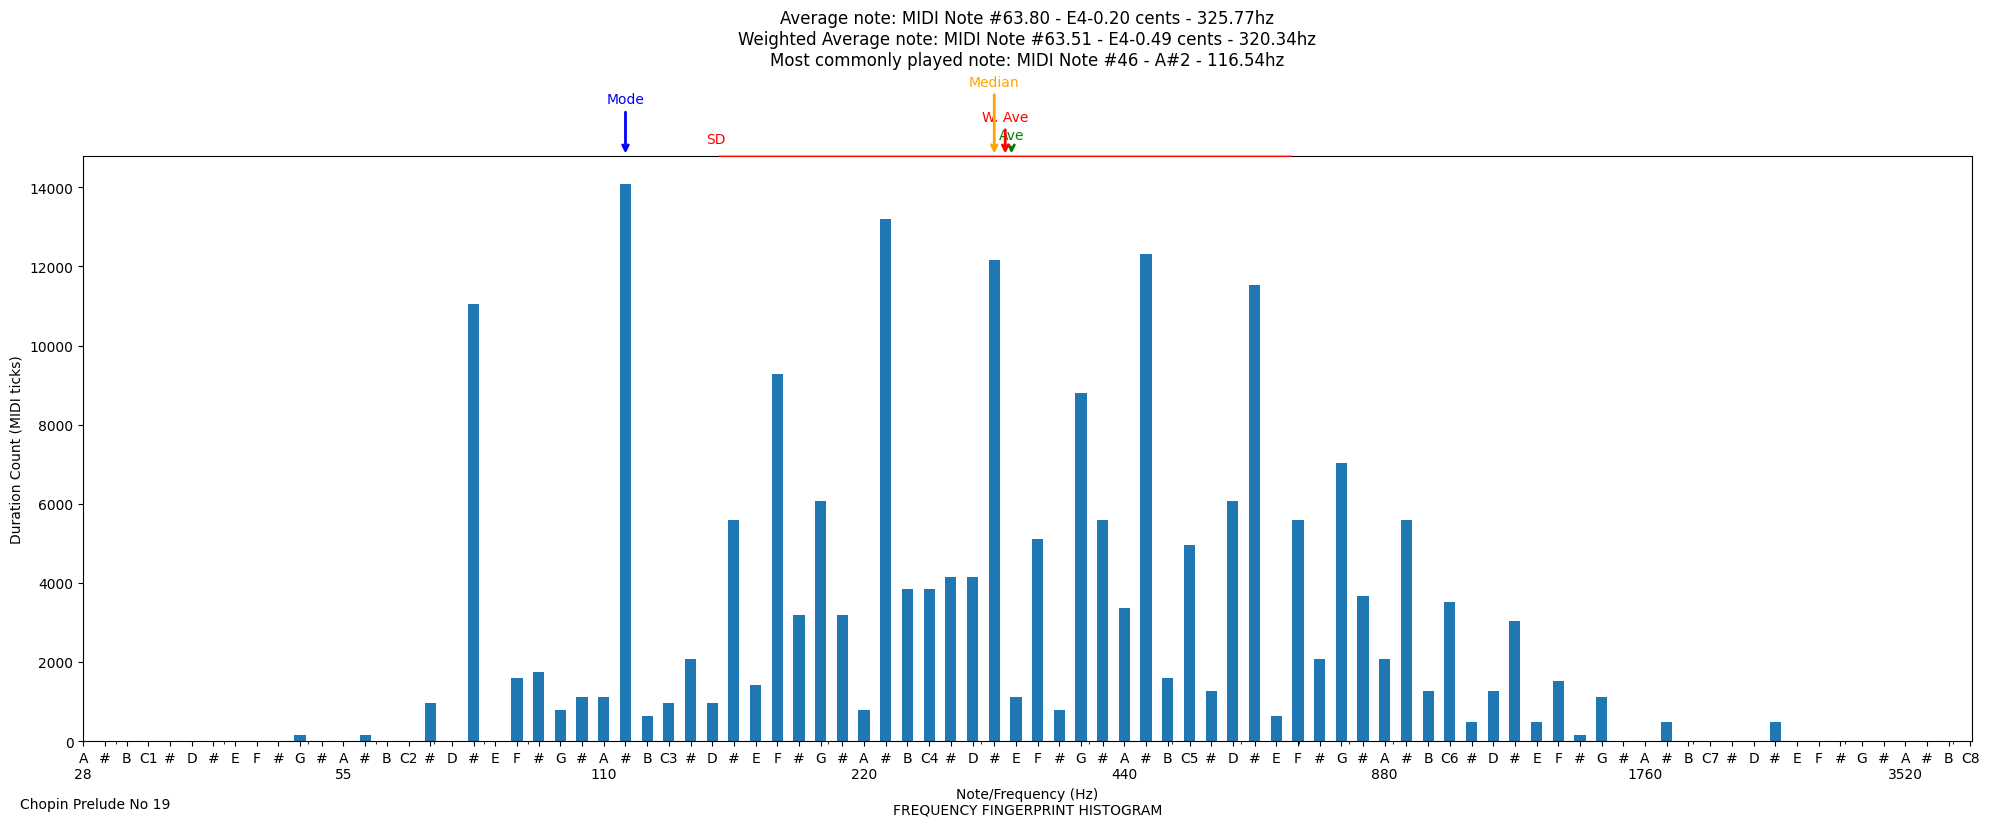

Button(description='Process and Play', style=ButtonStyle())

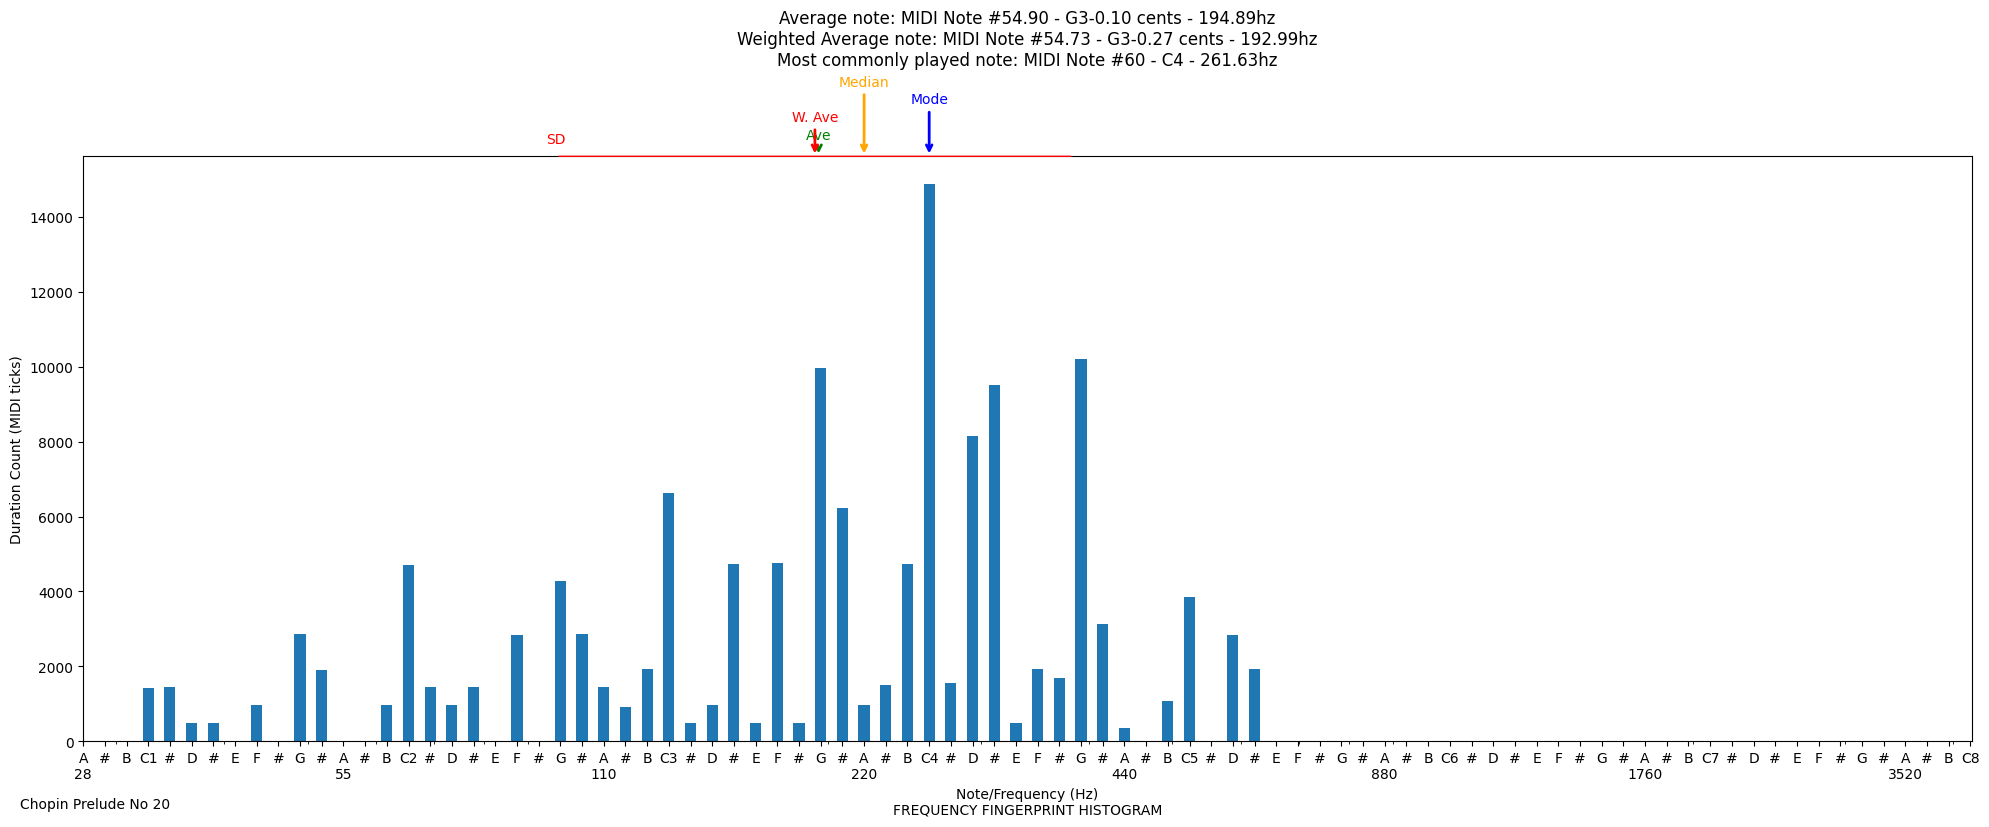

Button(description='Process and Play', style=ButtonStyle())

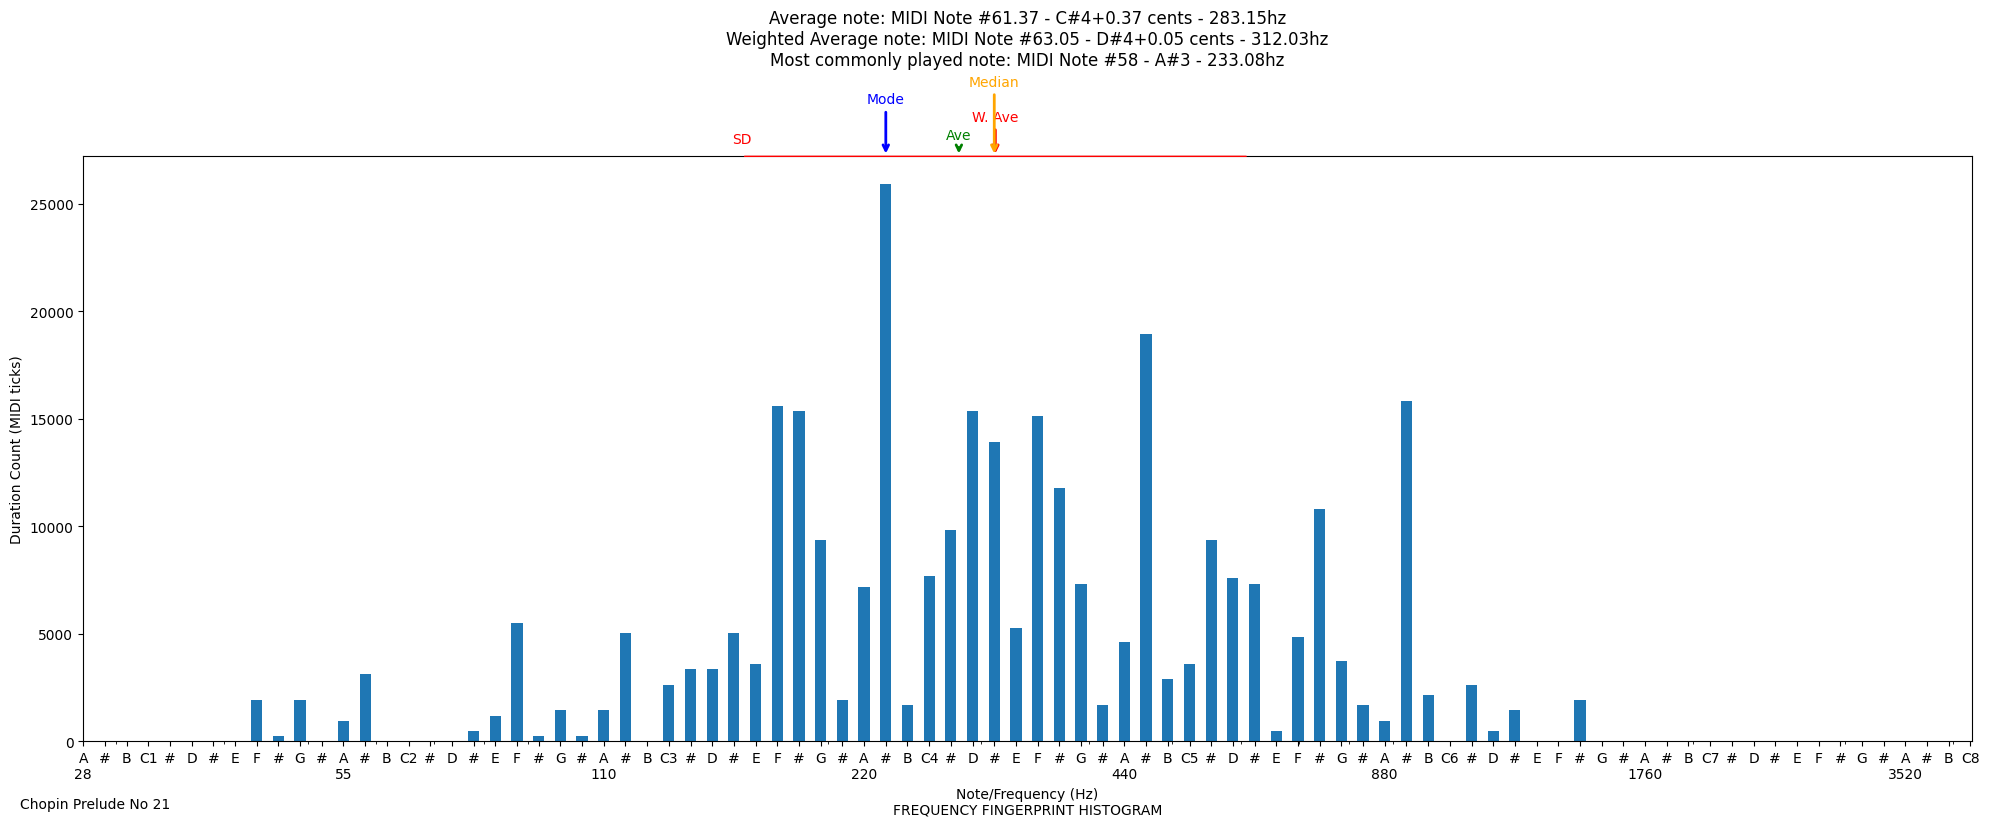

Button(description='Process and Play', style=ButtonStyle())

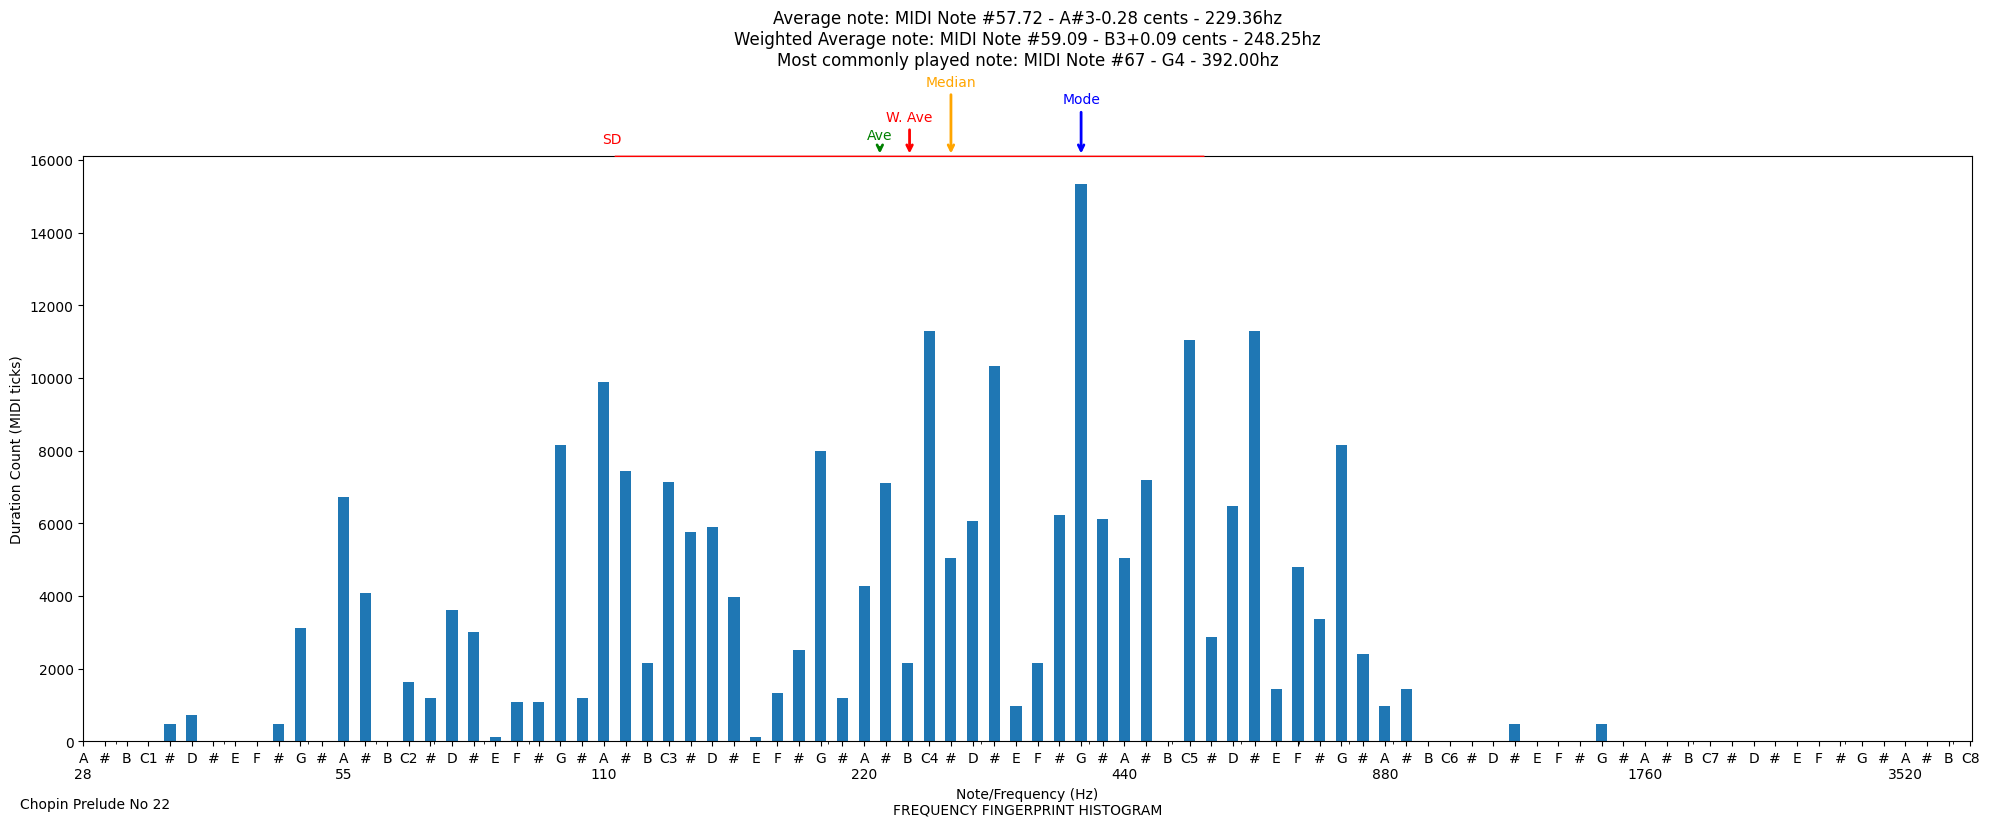

Button(description='Process and Play', style=ButtonStyle())

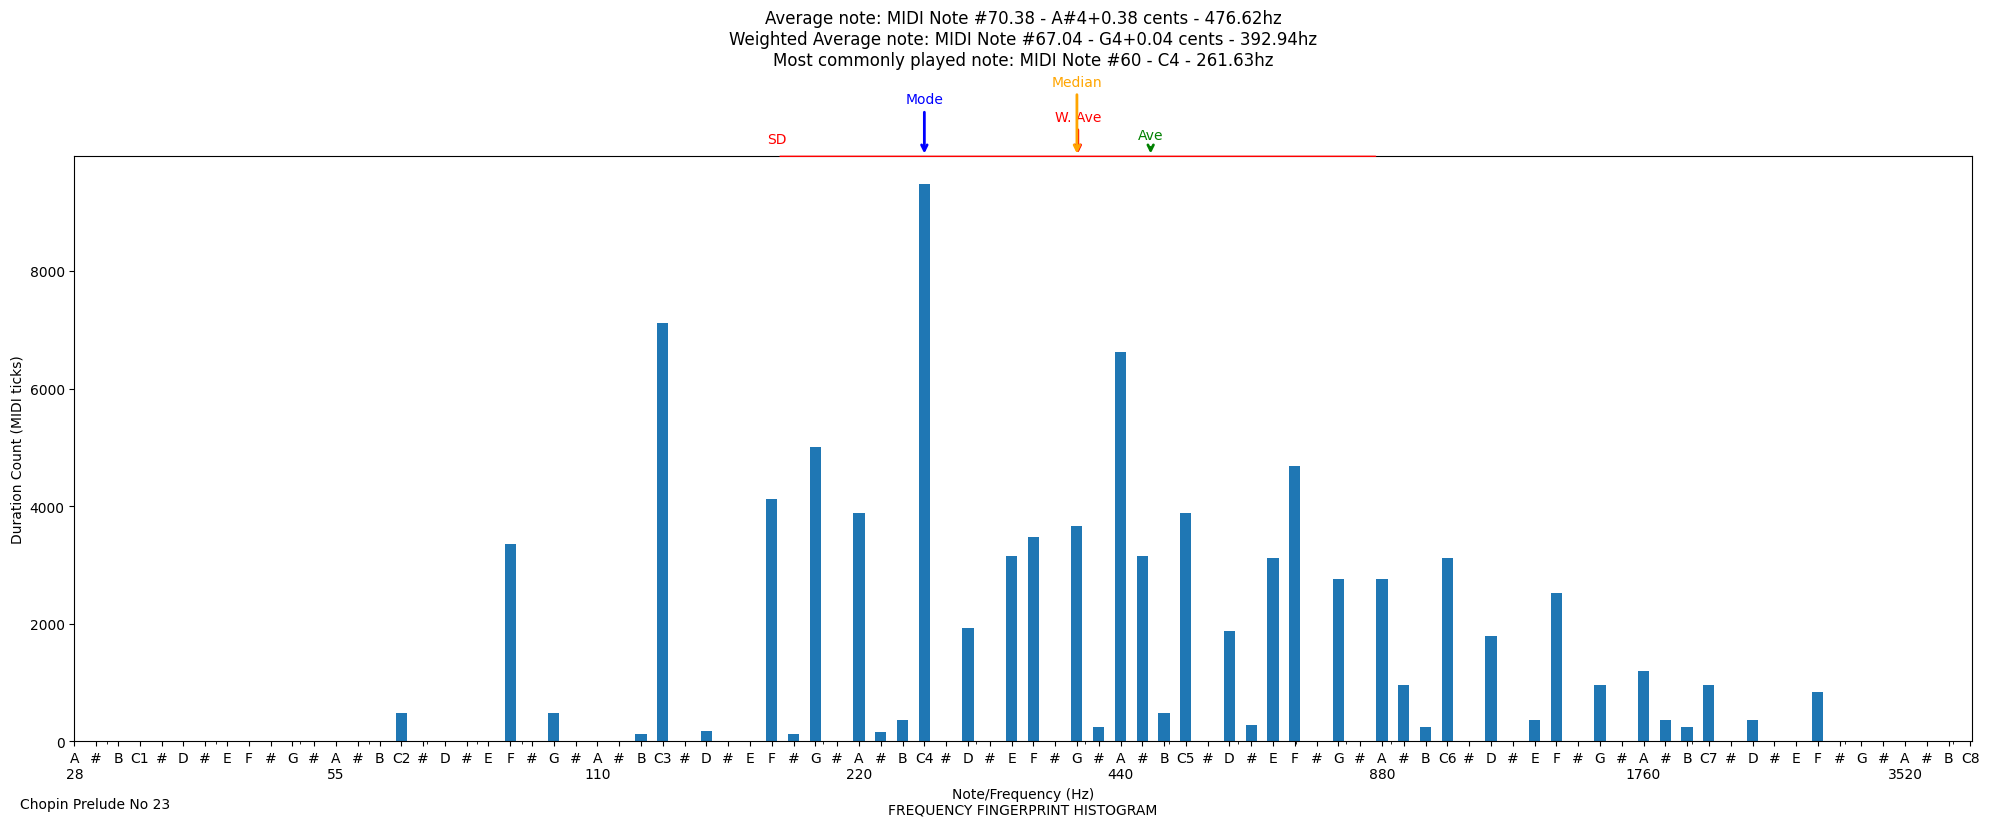

Button(description='Process and Play', style=ButtonStyle())

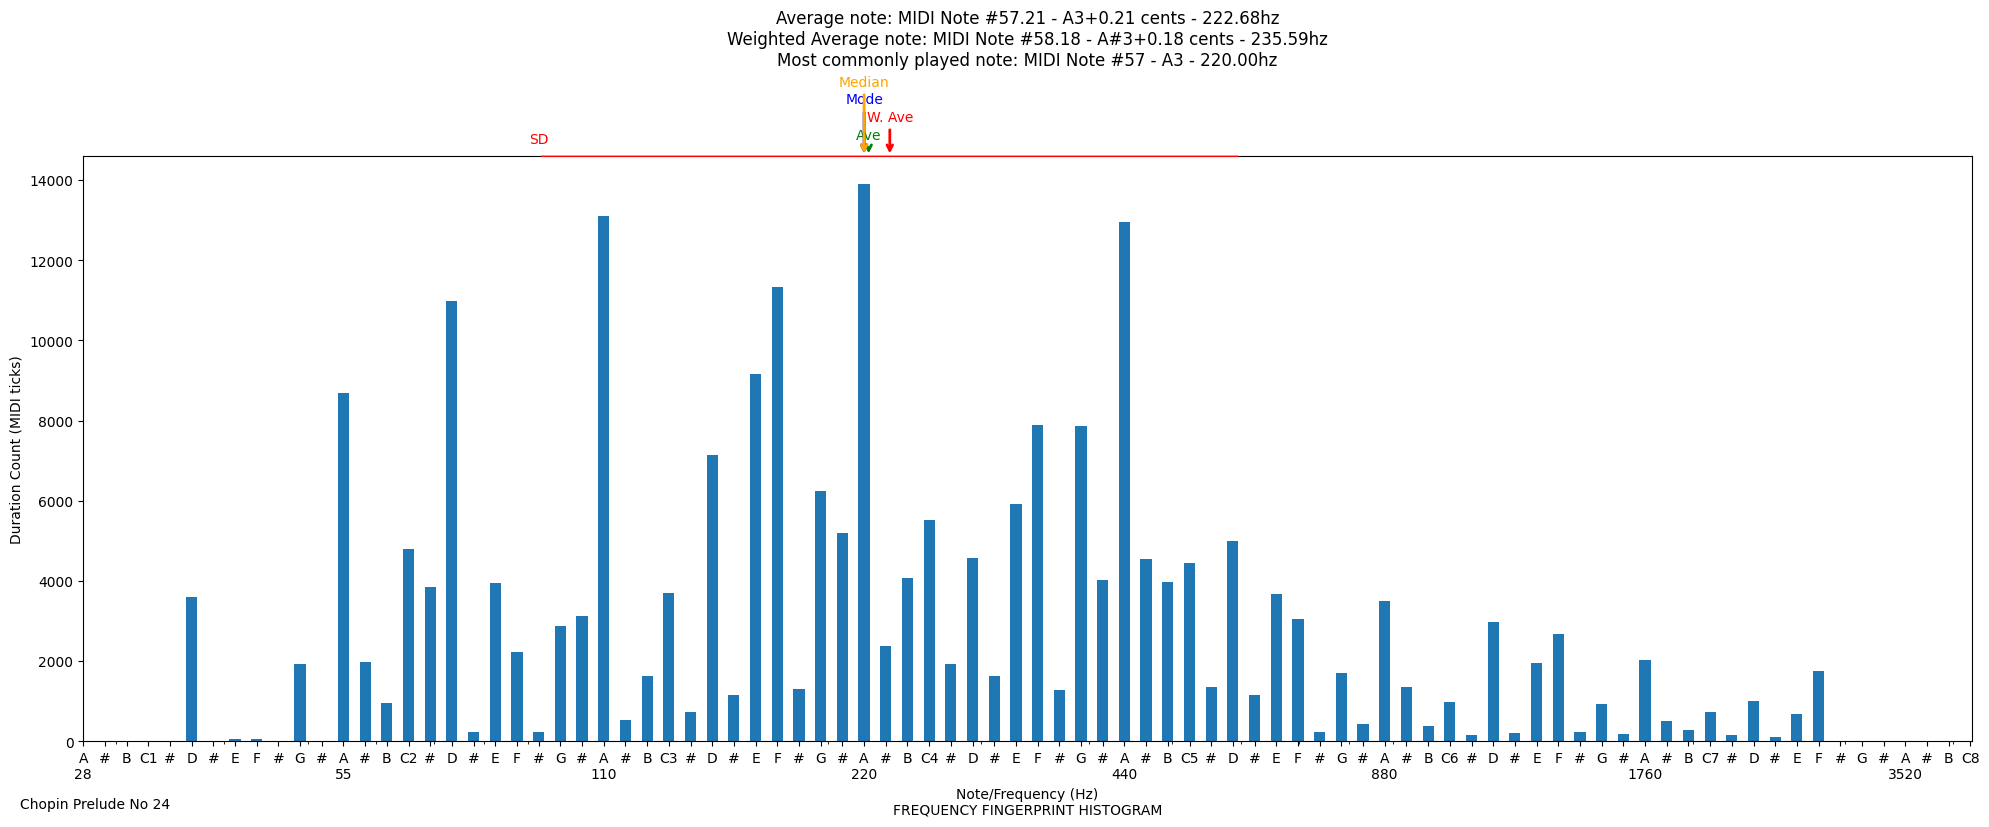

NameError: name 'AudioSegment' is not defined

In [46]:
%matplotlib inline

# @title
variable_name = ""
import ipywidgets as widgets
from IPython.display import display, clear_output, Video, FileLink
import os
import io
import sys
from google.colab import files
from contextlib import contextmanager
import tempfile
from moviepy.editor import *
import librosa
import soundfile as sf


###############################################################
# CHECKBOXES
#
display(HTML("<p><h3>Choose which elements to display:</h3>"))



histogram_checkbox = widgets.Checkbox(description='Show Histogram of Pitch Tallies', width = '800px', overflow_x='auto')

spectrum_checkbox = widgets.Checkbox(description='Show Power Spectrum Graph Rof Fingerprint')
waveform_s_checkbox = widgets.Checkbox(description='Show Waveform Segment of Fingerprint')
waveform_f_checkbox = widgets.Checkbox(description='Show Full Waveform of Fingerprint')

histogram_checkbox.value = histogram_checkbox_value
spectrum_checkbox.value = spectrum_checkbox_value
waveform_s_checkbox.value = waveform_s_checkbox_value
waveform_f_checkbox.value = waveform_f_checkbox_value

explanation0 = widgets.HTML(
    value='<p style="line-height: 1.1;"><i>If you want to see in more detail how the Histogram is converted into the audible Fingerprint, you can check the options for the Power Spectrum and Waveforms of the Fingerprint</i></p>'
)


histogram_checkbox.layout.width = '800px'
spectrum_checkbox.layout.width = '800px'
waveform_s_checkbox.layout.width = '800px'
waveform_f_checkbox.layout.width = '800px'



# Create a container Box with padding
container0 = widgets.VBox(
    [histogram_checkbox, spectrum_checkbox, waveform_s_checkbox, waveform_f_checkbox, explanation0],
    layout=widgets.Layout(
        padding='0px 0px 0px 80px',  # Apply padding to the container
        width='900px',
        #display='flex',  # Enable flexbox layout
        #justify_content='flex-start'  # Align content to the left
    )
)


#slider.layout.width = '600px'
#slider.layout.margin_left = '20em'

display(container0)  # Display the styled container


# Display checkboxes
#display(histogram_checkbox, spectrum_checkbox, waveform_s_checkbox, waveform_f_checkbox)

def spectrum_changed(change):
      #update the spectrum variable
      spectrum_checkbox.value = change['new']
      #print(change['new'])
      pass # or some other action
def histogram_changed(change):
      #update the histogram variable
      histogram_checkbox.value = change['new']
      #print(change)
      pass # or some other action
def waveform_f_changed(change):
      #update the waveform variable
      waveform_f_checkbox.value = change['new']
      #print(change)
      pass # or some other action
def waveform_s_changed(change):
      #update the histogram variable
      waveform_s_checkbox.value = change['new']
      #print(change)
      pass # or some other action
spectrum_checkbox.observe(spectrum_changed, names='value')
waveform_f_checkbox.observe(waveform_f_changed, names='value')
waveform_s_checkbox.observe(waveform_s_changed, names='value')
histogram_checkbox.observe(histogram_changed, names='value')


##########################################
# SLIDER - SMOOTHNESS
#

display(HTML("<p><h3>Fine-tune the sound:</h3>"))
# Create the slider
slider = widgets.FloatSlider(
    value=smoothness_slider_value,  # Initial value
    min=-5,
    max=100,
    step=0.1,  # Step size
    description='Smoothness:',
    readout_format='.1f',
    layout=widgets.Layout(width = '80%'),  # Changed to keyword argument
)

explanation = widgets.HTML(
    value='<p style="line-height: 1.1;"><i>Smoothness=0 is most realistic, keeping loudness of all pitches in exact proportion to the tally of notes as seen in the Histogram. Increasing Smoothness brings out the most prominent notes and de-emphasizes others - which is more to the point of a Frequency Fingerprint and often sounds better. </P><p style="line-height: 1.1;">If you are getting phaser type effects increasing smoothness will reduce or eliminate them.</P><p style="line-height: 1.1;">When fine-tuning a Fingerprint you can turn on the Fingerprint Power Spectrum and Waveform graphs to see how your changes are affecting the sound.</i></p>'
)
# Create a container Box with padding
container = widgets.VBox(
    [slider, explanation],
    layout=widgets.Layout(
        margin='0px 0px 0px 80px',  # Apply padding to the container
        width='900px',
        #display='flex',  # Enable flexbox layout
        #justify_content='flex-start'  # Align content to the left
    )
)


#slider.layout.width = '600px'
#slider.layout.margin_left = '20em'

display(container)  # Display the styled container

# Display the slider widget
#display(slider) # Display the slider separately

##########################################
# SLIDER - DURATION
#

display(HTML("<p><h3>Choose the length of the fingerprint (seconds):</h3>"))
# Create the slider
slider2 = widgets.FloatSlider(
    value=duration,  # Initial value
    min=0.05,
    max=10.05,
    step=0.05,  # Step size
    description='Length:',
    readout_format='.2f',
    layout=widgets.Layout(width = '80%'),  # Changed to keyword argument
)

explanation2 = widgets.HTML(
    value='<p style="line-height: 1.1;"></p>'
)
# Create a container Box with padding
container2 = widgets.VBox(
    [slider2, explanation2],
    layout=widgets.Layout(
        margin='0px 0px 0px 80px',  # Apply padding to the container
        width='900px',
        #display='flex',  # Enable flexbox layout
        #justify_content='flex-start'  # Align content to the left
    )
)


#slider.layout.width = '600px'
#slider.layout.margin_left = '20em'

display(container2)  # Display the styled container





#SELECT A MIDI FILE OR FILES FROM YOUR LOCAL DIRECTORY
#uploaded = files.upload("/content/MIDI Files/")

# Capture stdout
#old_stdout = sys.stdout
#sys.stdout = io.StringIO()

#############################################################
# CHOOSE FILES

display(HTML("<p><h3>Choose the files to process:</h3>"))
display(HTML("<p><i>&nbsp&nbsp>>>>If you </i><b>Cancel upload</b><i> the previous files will be re-processed</p"))



@contextmanager
def suppress_stdout():
    """Suppresses standard output within the context."""
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout

# Suppress standard output
with suppress_stdout():
  uploaded = files.upload("/content/MIDI Files/")

# Restore stdout
#sys.stdout = old_stdout
#print("Files uploaded successfully!")

if len (uploaded) > 0:
  filenames = list(uploaded.keys())  # Extract uploaded filenames

if len(filenames) < 1:
  display(HTML("<p><h3>You did not choose any files - exiting.</h3>"))
  raise SystemExit


from IPython.display import display, clear_output

# Your list of items
items = filenames

# Create a SelectMultiple widget
selector = widgets.SelectMultiple(
    options=items,
    value=[],  # Initially, nothing is selected
    description='Reorder:',
    rows=len(items),
    layout=widgets.Layout(width='90%'),
    disabled=False
)

# Create an Output widget to display the selected order
output = widgets.Output()

# Function to handle selection changes and update output
def on_selection_change(change):
    with output:
        clear_output(wait=True)

        # Get newly selected items
        newly_selected = [item for item in change['new'] if item not in change['old']]

        # Move selected items to the bottom of the options list
        current_options = list(selector.options)  # Get current options
        for item in newly_selected:
            if item in current_options:
                #current_options.remove(item)  # Remove from current position
                #current_options.append(item)  # Add to the end (bottom)
                #current_options.insert(0, item)  # Insert at the beginning
                current_index = current_options.index(item)
                if current_index < len(current_options)-1:  # Check if it's not already at the top
                    current_options.pop(current_index)  # Remove from current position
                    current_options.insert(current_index + 1, item)  # Insert one position higher

        selector.options = current_options  # Update widget options

        # Display the current order
        #print("Current Order:")
        #for i, item in enumerate(selector.options):
        #    print(f"{i+1}. {item}")


# Observe selection changes
selector.observe(on_selection_change, names='value')

display(HTML('<h3>Edit Processing Order</h3>You can edit the order in which the files will be processed.  Clicking a filename moves it downwards.'))

# Display widgets
display(selector, output)


#####################################################################
#  PROCESS THE MIDI FILES

# These now inited at open of session
#smoothness = 1
#duration = 3 # Duration of the sound in seconds


# Function to process the selected order (triggered by a button or other event)
def process_order():
    global filenames, smoothness, duration, histogram_checkbox_value, spectrum_checkbox_value, waveform_s_checkbox_value, waveform_f_checkbox_value, slider, slider2, smoothness_slider_value, image_list

    # Hide the widgets
    selector.layout.visibility = 'hidden'
    process_button.layout.visibility = 'hidden'
    spectrum_checkbox.layout.visibility = 'hidden'
    histogram_checkbox.layout.visibility = 'hidden'
    waveform_s_checkbox.layout.visibility = 'hidden'
    waveform_f_checkbox.layout.visibility = 'hidden'
    #output.layout.visibility = 'hidden' # If you want to hide the output as well

    # Clear the output
    clear_output()

    displayed_order = list(selector.options)
    # ... your processing logic here ...
    #print(f"Processing order: {displayed_order}")
    filenames = displayed_order

    #when calculating the frequency fingerprint,
    #the amplitude of the sine wave is raised to the power of *smoothness*
    #Thus powers > 1 will polarize it more, making the higher values higher & the lower ones relatively deemphasized
    #powers < will bring all amplitudes together in the center, all frequencies more even
    smoothness_slider_value = slider.value  # Get the current value
    smoothness = smoothness_slider_value/10 + 0.5

    duration = slider2.value  # Get the current value

    histogram_checkbox_value = histogram_checkbox.value
    spectrum_checkbox_value = spectrum_checkbox.value
    waveform_s_checkbox_value = waveform_s_checkbox.value
    waveform_f_checkbox_value = waveform_f_checkbox.value

    ####### start making a movie of the results
    image_list = []


    process_midi_files(filenames)

# Create a button to trigger processing (optional)
process_button = widgets.Button(description="Process Files")
process_button.on_click(lambda b: process_order())
display(process_button)



def process_midi_files(filenames):
  # @title
  # Parameters (you can change these as you like)
  global duration, sample_rate  # Declare duration and sample_rate as global


  #input_midi_file="https://www.classicalmidi.co.uk/5643rdpart.mid"

  big_signal = []

  #for filename in uploaded.keys():
  for filename in filenames:
      #print(filename)
      s=create_results(filename)
      #ret = ret1.copy()
      #s_max = np.max(np.abs(s))
      #print ("MAX ", s_max)
      #s = np.array([(s/ np.max(np.abs(s))) * 0.9]) #normalizing it slightly soft, .7
      big_signal.append(s)
      #print ("SAVEM", len(big_signal), len (s), len(big_signal))
      #signal_list.append(s)

  display(HTML("<p><b>=========================================</b></p>"))
  display(HTML("<p><b>  ALL FREQUENCY FINGERPRINTS IN SEQUENCE</b></p>"))
  display(HTML("<p><b>=========================================</b></p>"))
  #print (len(big_signal[0]))
  display(HTML("<p></p>"))

  #sigs = np.concatenate(big_signal)

  sigs = big_signal[0]  # Start with the first signal
  for i in range(1, len(big_signal)):
    sigs=overlap_audio (sigs, big_signal[i], overlap_duration=duration/3, sr=44100)
    #print (len(sigs))

  fd = 0.1
  if duration< 0.5:
    fd = duration/40

  sigs = fade_in_out_audio (sigs, fade_duration=fd, sr=sample_rate)

  audio36 = Audio(data=sigs, rate=sample_rate, normalize=False)
  display(audio36)



  # Create an AudioFileClip from sigs directly
  #audio_clip = AudioFileClip(io.BytesIO(sigs.tobytes()), fps=sample_rate, codec='pcm_s16le')
  os.makedirs("/content/temp", exist_ok=True)
  temp_audio_filename = '/content/temp/temp_audio.wav'  # Temporary filename


  sf.write(temp_audio_filename, sigs, samplerate=sample_rate)

  # Now use the temporary filename with AudioFileClip
  audio_clip = AudioFileClip(temp_audio_filename)

  # ... (rest of the function) ...
  from PIL import Image
  #im = Image.fromarray(arr)
  #im.save("your_file.jpeg")

  #Image.fromarray(image_list[0]).save('/content/first_image.png')
  #Image.fromarray(image_list[1]).save('/content/first1_image.png')
  #Image.fromarray(image_list[2]).save('/content/first2_image.png')
  ##########Make the MOVIE

  # Set a reasonable FPS (e.g., 25)
  fps = 60

  total_images = fps * audio_clip.duration

  # Duplicate images in the list
  #repeated_image_list = [img for img in image_list for _ in range(repeat_count)]
  # Calculate base repeat count using integer division
  base_repeat_count = int( total_images // len(image_list))

  # Calculate remaining frames
  remaining_frames = total_images % len(image_list)

  repeated_image_list = []
  for i, image in enumerate(image_list):
      # Repeat image base_repeat_count times
      repeated_image_list.extend([image] * base_repeat_count)
      # Add an extra frame if within remaining_frames
      if i < remaining_frames:
          repeated_image_list.append(image)

    #repeated_image_list = image_list
  last_img = image_list[-1]
  repeated_image_list.extend([last_img] * fps) # add 1 second extra frames @ end

  # Create a silent segment
  silence_duration = 100  # milliseconds
  silent_segment = AudioSegment.silent(duration=silence_duration)

  # Crossfade with the silent segment
  audio_clip = audio_clip.append(silent_segment)  # Adjust crossfade duration


  # Calculate duration in seconds
  audio_duration = len(audio_clip) / sample_rate
  clip = ImageSequenceClip(repeated_image_list, fps=fps).set_duration(audio_duration).set_audio(audio_clip)

  #clip2 =ImageClip(image_list[0]).set_duration(5)
  # Use repeated_image_list
  #clip.list_images = repeated_image_list  # Update list_images
  #clip.duration = len(repeated_image_list) / clip.fps  # Update duration
  #audio_clip.duration = clip.duration  # Ensure audio and video have the same duration
  #clip.set_audio(audio_clip)

  # (Optional) clean up the temp file
  #os.remove(temp_audio_filename)

  video_tmp = '/content/all_fingerprints_movie.mp4'
  clip.write_videofile(video_tmp, codec='libx264', audio_codec='aac', fps = fps)  # Save video

  # Define a function to trigger the download
  def download_movie(b):
    #display(FileLink('/content/all_fingerprints_movie.mp4'))
    files.download(video_tmp)

  download_button = widgets.Button(description="Download Movie")
  download_button.on_click(download_movie)  # Attach the download function

  # Display the button
  display(download_button)

  '''
  video_tmp2 = '/content/all_fingerprints_movie2.mp4'
  clip2.write_videofile(video_tmp2, codec='libx264', audio_codec='aac', fps = fps)  # Save video without audio
  '''

  video_tmp2 = '/content/all_fingerprints.gif'
  clip.write_gif(video_tmp2, fps=24)
  # Define a function to trigger the download
  def download_movie2(b):
    #display(FileLink('/content/all_fingerprints_movie.mp4'))
    files.download(video_tmp2)

  # Create a download button using ipywidgets

  download_button2 = widgets.Button(description="Download GIF")
  download_button2.on_click(download_movie2)  # Attach the download function

  # Display the button
  display(download_button2)



  #video_tag = f'<video width="640" height="480" controls><source src="all_fingerprints_movie.mp4" type="video/mp4"></video>'
  #display(HTML(video_tag))  # Display the video within the cell

  display(Video('all_fingerprints_movie.mp4', embed=True, width=640, height=480))


  display(HTML("<p><b>=======END OF RESULTS===========================================================================================</b></p>"))





# Documentation, Background, and Credits

## Frequency Fingerprints results - what you are hearing and seeing


*   For each MIDI file you upload, these results are shown:
 * **Average pitch** - calculated two ways: A simple count of notes played, or a weighted count taking into consideration how long the note was held
 * **Most commonly played note**
 * **A control box to play the sound file of the Frequency Fingerprint.** You can play the sound from your browser, or click the three dots menu to save the file.
 * **Right below the Fingerprint control, a link to download/play the MIDI file.** It is often instructive to go back and forth between listening to the Fingerprint and the actual music file.
 * **A graphical display of the Frequency Fingerprint** showing relative frequency of each note played in the MIDI file.  This is also the frequency graph (Fourier Transform) of the Frequency Fingerprint sound. See below for more info.
 * **A histogram showing the exact frequency of each pitch (note) in the work**
 * **A graph showing a short snippet of the waveform of of the Fingerprint**
*   At the very end of the output is **a longer sound file playing the Frequency Fingerprints for each of your MIDI files in sequence.**

You can choose checkboxes to omit any of the graphs from the output.

You can use a slider to fine-tune the sound of the Frequency Fingerprints.  The slider controls how much prominent notes are emphasized or de-emphasized in comparison to other notes. With slider settings greater than 1, you hear only the most prominent notes and others are de-emphasized.  Some find this result is more harmonious.

### How a Frequency Fingerprint sound file and graph are created
The code simply tallies each note played in the MIDI file - including how long it was held.

The result is a long list of every note from A0 to C8 and a total of how many times it was played - or more precisely, how much time in total each note was played.

Those values are then interpreted as sound frequencies - each frequency being louder or softer in proportion to how many times that note was played.

The Frequency Fingerprint sound file is created by creating a tone at each of those frequencies.  The tone is very loud for the notes that were played a lot, soft for those notes played less frequently, and silent for any notes never played.  All those tones are then combined - played all together at once - to create the Frequency Fingerprint sound file.

We can then take that sound and analyze its frequencies. That is the graphical version of the Frequency Fingerprint that you see.

### What is the waveform?
The waveform shown is simply a graph showing short snippet of the Frequency Fingerprint sound's waveform.

It is zoomed in to show a very short time interval, so that you can see the details of the waveform more clearly.

### What the Frequency Fingerprint tells you and why it is interesting
A Frequency Fingerprint is interesting on its own and gives you some high-level insight into a piece of music.

Which notes are played more often?  Which are never played?  Which areas of the sound spectrum are used most often, and which rarely or never?

In particular, there is almost always one note - occasionally two or three - that is clearly played far more often than the others.  Then there is a group of 3-4 notes just below that, and then 8-12 notes below those. So of all the musical notes there are, usually just a handful play the most important roles in any piece.

In tonal musical styles, you can usually pick out the dominant (5th degree of the scale) which is almost always the most frequenctly played note, and the tonic (1st degree of the scale).  

In other musical styles, the frequency at which various notes are played can give insight into which scales or tonal schemes are being used, and which notes within them are playing the most important roles.

You will note that the human vocal range is generally where most notes in most musical styles are located.  It is interesting to see which exact areas of the pitch spectrum are being used in a particular work

For example, some works will focus more in the lower (tenor or baritone) range, while others are more centered on Middle C, and others more focused on the upper/soprano ranges. And it is very common to see a bifurcation: Heavy emphasis on bass - often quite low bass - and then in the soprano region.

Which tessatura or tessaturas a particular piece focuses on is, again, one of the most basic facts about the piece that shapes our perception and reception of it.

So these basic facts and statistics about the pitches used in a work is very, very basic information about any musical work - but for that very reason, the insights from seeing and hearing the Frequency Fingerprint can be pretty profound.  Before the advent of computers, it was not easy to calculate or view such basic information about a piece.

In addition, the sonic version of the Frequency Fingerprint gives a way to instantly grasp and perceive a kind of summary of the entire work.

## Analyzing several pieces or movements

The Frequency Fingerprint is and interesting and useful concept on its own.  But comparing the Fingerprints of different music is even more revealing.

You can generate and compare Fingerprints for different movements of a single work, different sections within a single work, different pieces by the same composer, works of different composers, and works of different styles and time periods.

For example, listening to (and viewing) the Fingerprint of each movement of a symphony, suite, sonata, set of pieces, tracks on a recording, or other works meant to be heard in succession is often very insightful.

Viewing the fingerprints of different sections of a work can also be insightful: For example, breaking a sonata form movement into different MIDI files for exposition, development, and recapitulation can yield interesting insights.  Other subdivisions are possible as well: First theme, second theme, and so on.

When you choose MIDI files for analysis in this software, you can choose several files at once. They will be processed in the order chosen.  You may need to rename the files, or re-sort your directory (for example, add 1, 2, 3, 4... to the beginning of the filenames, then sort the directory by name), so that the files are listed in order and will be processed in the order you wish.

At the very end of the results, a sound file is created that plays all the Fingerprints of each file uploaded, in quick succession.  This is often the best way to get the overview of, for example, a multimovement work that is most helpful and insightful.

## Why is does the Frequency Spectrum of the Frequency Footprint look different from the Histogram?

The Histogram shows the exact count (of MIDI "ticks") corresponding to the length of time each musical note was played in the file.

The Frequency Fingerprint audio file is created by adding together sine waves at the frequency of each note, with the amplitude (volume) determined by the corresponding value in the Historgram for that note.

Then we make the Frequency Spectrum by taking a Fast Fourier Transform (FFT) of that audio file.  This shows each frequency and how strong it is.

However, the FFT process is somewhat imperfect. It is a "convolution algorithm" that can approximate frequencies and amplitudes within certain limits depending on the length of the sound, number of sound samples available, and other factors. So it is a bit like translating an English sentence into four foreign languages in turn, then back to English.  In theory you will get the exact sentence back - in practice it is usually an approximation.

In addition, very thin lines of the Spectrogram often disappear when the graph is reduced in size.  Click the graph for the full-sized version. In theory, because of the way the sound file was created, each peak of the Spectrogram is, literally, infinitely thin.  That means it is challenging to both measure and graph.

And you will find moving the Tone Adjustment Slider significantly affects the look the Spectrogram - and the corresponding sound of the Fingerprint.  A value greater than one will "polarize" the results, strongly emphasizing the few notes with the highest tallies, and de-emphasizing those with lower tallies.  You will see this reflected in the Spectrogram.

Moving the slider to values less than 1 will have the opposite effect: Note volumes are more equalized and all volumes are brought closer to the center. A value somewhere between 0.5 and 1 often makes the Histogram and Spectrogram *visually appear* the most similar.  You can hear a basic similarity to the sound through the whole range of the tone adjustment, however - so the difference is likely more in details about the appearance of the Spectrogram than in important difference in the sound itself.

That is why both the Histogram and the Frequency Spectrum are displayed: The Histogram is exact in displaying the tally for each pitch. The Frequency Spectrum demonstrates how faithfully this data can be transformed into sound - that the result is, truly, startlingly good.

But: If you are settling an argument with a friend about whether F#4 or C#3 was played more often in the Moonlight Sonata, it is best to consult the Histogram for the exact answer.

### Example: Moonlight Sonata

This software comes pre-loaded with a Fingerprint analysis of the three movements of Beethoven's Moonlight Sonata. You will be able to view and hear these Fingerprints simply by scrolling and viewing - before you run any code or upload files of your own.

(If you can't see this analysis, you can easily create your own by searching online for MIDI files of the Moonlight - as three separate files for each movement - and then uploading and processing them according to the instructions above.)

When you listen to and view the Moonlight Sonata Fingerprints, a few interesting facts become immediately apparent:

* **The first movement has a low tessatura, the 2nd movement a middle tessatura, and the 3rd movement a higher tessatura.**

The Moonlight is, famously, a sonata in which the first movement is slower tempo, the second movement moderate tempo, and the third movement fast tempo.

The low, moderate, and high tessaturas of the three movements are just as obvious and just as important in supporting this scheme.  However, until you see the pitch content of a work summarized in this way, it is easy to miss.

When you hear the Fingerprints of the three movements in succession, the progression low-medium-high frequency is very obvious.

Looking at the average pitch for each movement is telling as well: Rising from E3 to B3 to C4.

* **The frequency of notes played is telling**
In each movement, G# stands out as a most frequently played note in several octaves.  This of course the dominant in each movement (1st movement c# minor, 2nd movement Db major - so Ab is the dominant; enharmonically G#, and 3rd movement c# minor).

So the frequent use of the dominant tone is notable, and C#/Db is also very commonly used. You will note the different in frequency of E vs F in the various movements (E is far more common in the minor movements).  Altogether, you can garner a good deal of information about the tonality and scales used in the work, which pitches are more important and which less important, simply by looking at note frequences.

* **Which note (and notes) dominate**
It is interesting the degree to which a certain G#/Ab dominates each movement - note just F#s in general, but one particular F# in a particular octave.

The 1st movement has just three notes with power above 1.5 (note Y axis scale) while the 2nd & 3rd movements have just one note each.

Note how many notes are above power 1.5, 1.0, and 0.5 in each movement - the differences are quite telling.  The first movement very much concentrates on just three notes (G#1, C#2, G#2) and then three in a second tier. Whereas the other movements have one note in a tier of its own and 6-7 notes in a second tier.

Again, these commonly-played notes tend to be important notes in the tonality of the work.

With the Fingerprints, you can see and hear basic facts such at these at a glance - or a quick listen.





## Frequency Fingerprints - More details, background, credits

### What the program does
The Frequency Fingerprint totals up all the pitches of notes of the work, weighted by the number of times each note was played and how long it was held. You can then both hear and see the results. Average & most commonly played pitches are also shown.

It then plays all notes of the entire piece simultaneously, with notes that were played more often throughout the work louder, less frequent notes/pitches softer, and notes/pitches never played completely silent.

The result is a "chord" that sums up the entire piece - with notes of the chord louder or softer for more and less prominent notes of the work. You can listen to that chord below.

Graphs showing the waveform and a Frequency Histogram of the Frequency Fingerprint are also shown below.

In addition, the average pitch and weighted average pitch are calculated for each file.  (Average pitch counts only how many times each note is played, while weighted average also takes into account the duration each note is held. The Frequency Fingerprint also takes note duration into account.)

### Why
This project was spurred by a simple question by user u/oswaler on Reddit: *What is the average pitch in Beethoven's ninth symphony?*

That is a simple yet quite profound question - and it is not very easy to find an accurate answer.  User u/CptanPanic came to the rescue with code to count the notes in a MIDI file and find the average pitch.

I experimented with CptanPanic's code, and quickly realized it was possible to create a histogram of how often all notes up and down the frequency spectrum are played, and tally them into a big array.  Some of this was inspired by the [Humdrum Project](https://www.humdrum.org/), dedicated to creating tools for the computer analysis of music, which I have been following since the 1990s. For example, they have note-frequency histograms pre-calculated for a large number of works.

Finally, while implementing the ideas above, I happend to see code by Max B. that provided a simple way to turn a list of frequencies and amplitudes into a sound file.  That kind of a list is, of course, exactly what the note frequency lists that we were creating from MIDI files are.  

Putting all those ideas together is how Frequency Fingerprints were born.

A similar idea involves starting with a music recording, analyzing the sound file for frequencies over time, creating a similar list of note frequencies with magnitudes measuring how prominent the note was throughout the work, and then producing a Frequency Fingerprint directly from that audio file.

That project is underway with working code that provides as many or more interesting insights about an audio file as we are able to glean from the MIDI file.  See both the MIDI and Audio File versions of the code on the [Frequency Fingerprint Github Page](https://github.com/bhugh/FrequencyFingerprint).

User u/oswaler was inspired in his question by movie buffs who have spent time computing the "average color" of movies.  This [can](https://moviepalette.com/) [be](https://www.wired.com/2014/09/cinema-is-evolving/#:~:text=Cutting%20is%20also%20investigating%20the,decades%20since%20color%20was%20introduced.) [done](https://www.instagram.com/movieluts/reel/C379x1CCaOx/) [a](https://happycoding.io/gallery/movie-colors/) [few](https://www.reddit.com/r/dataisbeautiful/comments/3rb8zi/the_average_color_of_every_frame_of_a_given_movie/) [different](https://thecolorsofmotion.com/) [ways](https://github.com/christianp05/average-color-of-frame) - and is both interesting and sometimes quite insightful. The Frequency Fingerprint it designed to be a similar concept for music and audio.

In particular, taking the Fingerprint of different sections or movements of a work and then playing through them quickly in sequence, is closely analagous to the typical approach to average color, where the average color of a frame, or a few frames, is computed. These frames are then arranged sequentially like a spectrum.

### Input files - MIDI
The input source for creating a Frequency Fingerprint is a MIDI file - or several files, which are processed in sequence.  

You can use this code to create Frequency Fingerprint of any musical work you like - any work for which a MIDI file is available. MIDI files for most works in the public domain are easily available - just search Google for "*Composer - name of work* + MIDI".

So you can generate a Frequency Fingerprint for just about any musical work, piece, or song you like.

As mentioned above, a parallel project will allow you to create a Frequency Fingerprint from any audio file.

### Run the code here OR copy & experiment
You can run the code and generate Frequency Fingerprints from MIDI files using the sandbox version of the software.  It is hosted on Google's Colab server.  You can view the documentation, code, and sample output anonymously, but to run the code and generate your own Frequency Fingerprints, you will need to log in with a google account.  Then you can run the notebook and generate Fingerprints as outlined in the instructions at the very top.

You can also make a copy of the Notebook in your own Google Drive/Colab space (File/Save a Copy in Drive at the upper left).

Another option is to download this code and run the script locally (Python).  You'll need to install python and at least a couple of packages (*pip install mido*, *apt install python3-pyaudio*). It will probably take some work to adapt the program to run standalone - but you are welcome to do so.

### Credits & Resources

- [Frequency Fingerprint Github Page](https://github.com/bhugh/FrequencyFingerprint)

- The code to produce the waveform from frequencies and amplitudes was borrowed and modified from Max B. - https://www.kaggle.com/code/max398434434/generate-sound-from-frequencies-and-amplitudes

- Code to parse the MIDI file and calculate average pitch of the file was borrowed and modified from u/CptanPanic - https://www.reddit.com/r/classicalmusic/comments/1gpcjtd/comment/lwqda

- The [Humdrum Toolkit for computer analysis of music](https://www.humdrum.org/) and, particularly, [KernScores](https://kern.humdrum.org/), which collects electronic versions of many composers' scores in formats suitable for different types of analysis, and has a number of pre-calculated analyses - including text-format histograms of note frequency - available for many works.

- This entire project was spurred by a question on r/ClassicalMusic by u/oswaler: https://www.reddit.com/r/classicalmusic/comments/1gpcjtd/what_is_the_average_pitch_in_beethovens_ninth/

In [43]:
import pretty_midi
import fluidsynth
#import pyfluidsynth
from IPython.display import Audio, display
#from fluidsynth import Synth # import Synth from fluidsynth

def midi_play_widget(midi_file_path):
  """Plays a MIDI file in the notebook.

  Args:
      midi_file_path (str): Path to the MIDI file.
  """

  # Load the MIDI file using pretty_midi
  midi_data = pretty_midi.PrettyMIDI(midi_file_path)

  # Synthesize audio from MIDI data using fluidsynth
  # Adjust the sample rate if needed
  fs = fluidsynth.Synth() # initialize Synth
  fs.start()

  soundfont_path = "/content/FluidR3_GM.sf2"  # Update if you saved it elsewhere
  sfid = fs.sfload(soundfont_path)

  fs.program_select(0, sfid, 0, 0)  # Select the desired soundfont and instrument
  #midi_data.fluidsynth

  audio_data = midi_data.synthesize() # Use fluidsynth to generate audio data

  # Stop fluidsynth
  fs.delete()

  # Create and display an Audio widget for playback
  display(Audio(audio_data, rate=44100))

